# Neural Networks Project
## Road Segmentation using Fully Convolutional Neural Networks
### Group 6
Adwait Kalsekar - ak2521 \
Nidhi Jha - nj386 \
Parth Thaker - pt439 \
Vishal Pawar - vp611 \
Yunqiao Xu - yx403

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode
import math

## Load Dataset

### Source Dataset

In [ ]:
# Load directories
train_data_dir = "/content/drive/MyDrive/Neural_Network_Project/road_segmentation/training/image_2"
train_gt_dir = "/content/drive/MyDrive/Neural_Network_Project/road_segmentation/training/gt_image_2"

test_data_dir = "/content/drive/MyDrive/Neural_Network_Project/road_segmentation/testing"

In [ ]:
# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [ ]:
# Initialize Constants
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

In [ ]:
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])

    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
all_dataset = tf.data.Dataset.list_files(train_data_dir + "/*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

### Apply Transformations

In [ ]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


Filepath:  /content/drive/MyDrive/Neural_Network_Project/road_segmentation/saved_pred_masks/sample/display_sample (7).png


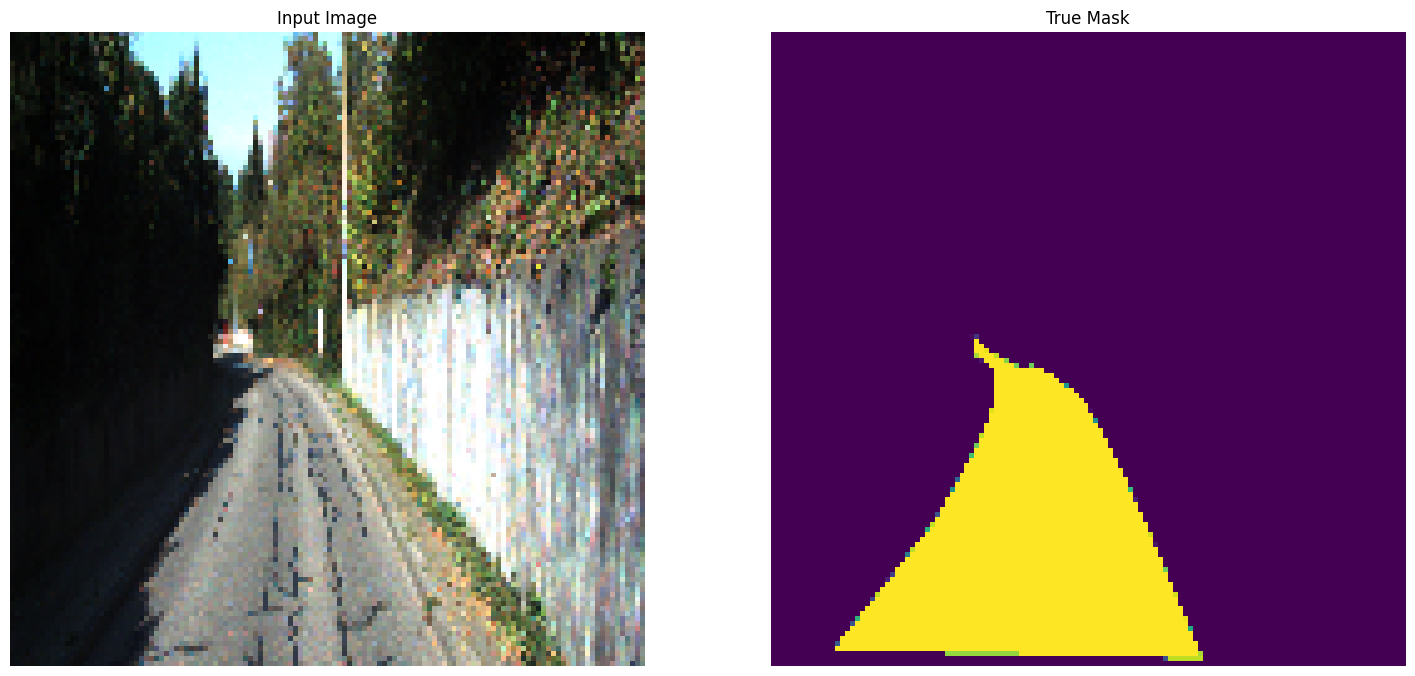

In [ ]:
def get_unique_filepath(filepath):
    base, extension = os.path.splitext(filepath)
    counter = 1
    while os.path.exists(filepath):
        filepath = f"{base} ({counter}){extension}"
        counter += 1

    print("Filepath: ", filepath)
    return filepath

# Function to view the images from the directory
def display_sample(display_list, filename=None):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    if filename:
        unique_filepath = get_unique_filepath(f'/content/drive/MyDrive/Neural_Network_Project/road_segmentation/saved_pred_masks/{filename}.png')
        plt.savefig(unique_filepath)
    plt.show()

for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]], 'sample/display_sample')



## VGG16

In [ ]:
# Get VGG-16 network as backbone
vgg16_model = VGG16()
vgg16_model.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# Define input shape
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [ ]:
# Generate a new model using the VGG network
# Input
inputs = Input(input_shape)

# VGG network
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs)

# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output

# Decoder
u1 = UpSampling2D((2, 2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

VGG_model = Model(inputs, outputs, name = "VGG_FCN8")

58889256/58889256 [==============================] - 4s 0us/step


## Training

### Loss Function

In [ ]:
m_iou = tf.keras.metrics.MeanIoU(2)
VGG_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[m_iou])

### Check Model

In [ ]:
# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)

    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(file_to_save, model, dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)], file_to_save)
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0], inference[0]], file_to_save)

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask



1/1 [==============================] - 6s 6s/step
Filepath:  /content/drive/MyDrive/Neural_Network_Project/road_segmentation/saved_pred_masks/sample/initial (5).png


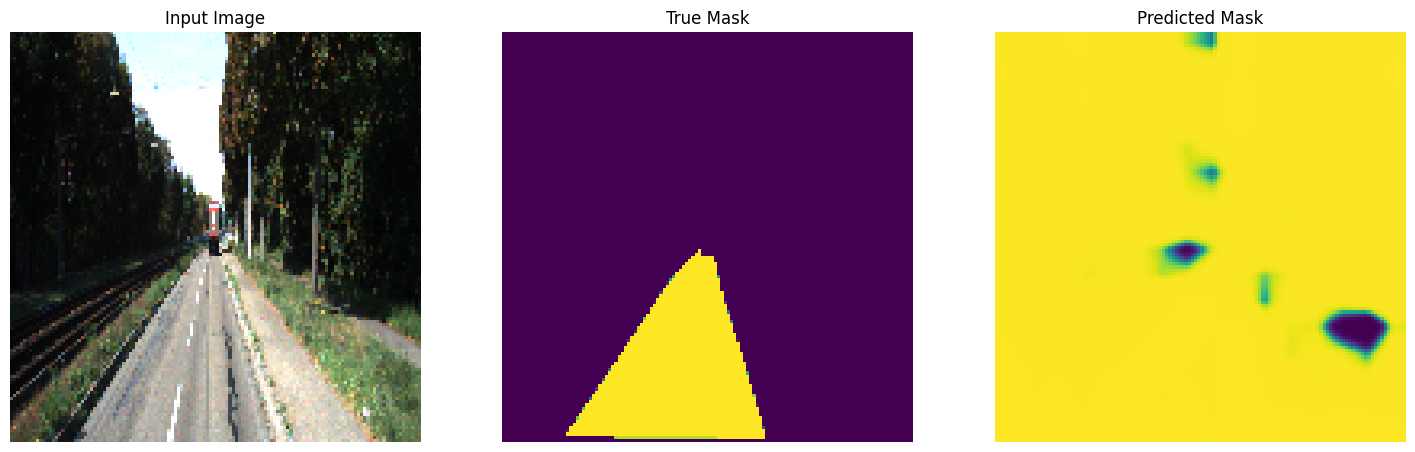

In [ ]:
show_predictions('sample/initial', model=VGG_model)

### Train Model

In [ ]:
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions('VGG_outputs/input_true_pred', model=VGG_model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("/content/drive/MyDrive/Neural_Network_Project/road_segmentation/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callback_functions = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('/content/drive/MyDrive/Neural_Network_Project/road_segmentation/Trained_models/VGG/best_model.h5', verbose = 1, save_best_only = True)
]


In [ ]:
# Set Variables
EPOCHS = 100
STEPS_PER_EPOCH = math.ceil(TRAINSET_SIZE / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(VALIDSET_SIZE / BATCH_SIZE)

1/1 [==============================] - 0s 21ms/step
Filepath:  /content/drive/MyDrive/Neural_Network_Project/road_segmentation/saved_pred_masks/VGG_outputs/input_true_pred (148).png


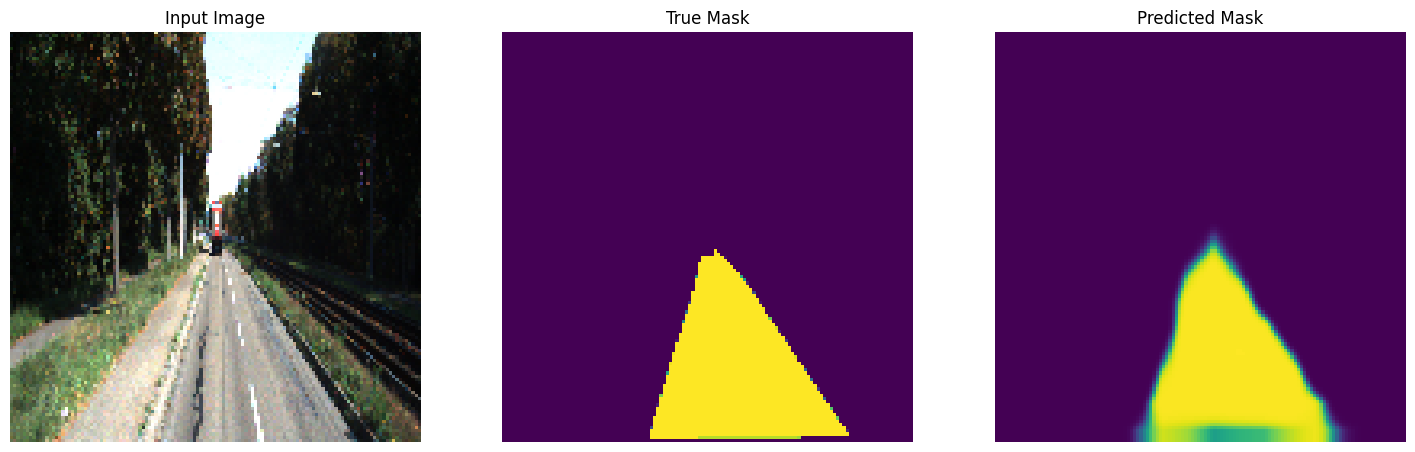


Sample Prediction after epoch 89


Epoch 89: val_loss did not improve from 0.04446
8/8 [==============================] - 27s 4s/step - loss: 0.0456 - mean_io_u: 0.4130 - val_loss: 0.0467 - val_mean_io_u: 0.4134
Epoch 89: early stopping


In [ ]:
VGG_model_history = VGG_model.fit(dataset['train'], epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data = dataset["val"], validation_steps=VALIDATION_STEPS, callbacks=callback_functions)

## Testing (Test Dataset)

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, alpha=1., beta=0.5, gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)

    # Convert to image image
    image = np.asarray(image, np.float32)

    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    print(model.summary())
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.savefig(f"/content/drive/MyDrive/Neural_Network_Project/road_segmentation/outputs/UNet/{index}.png")
    plt.show()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                               
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 96)           6240      ['max_pooling2d[0][0]']    

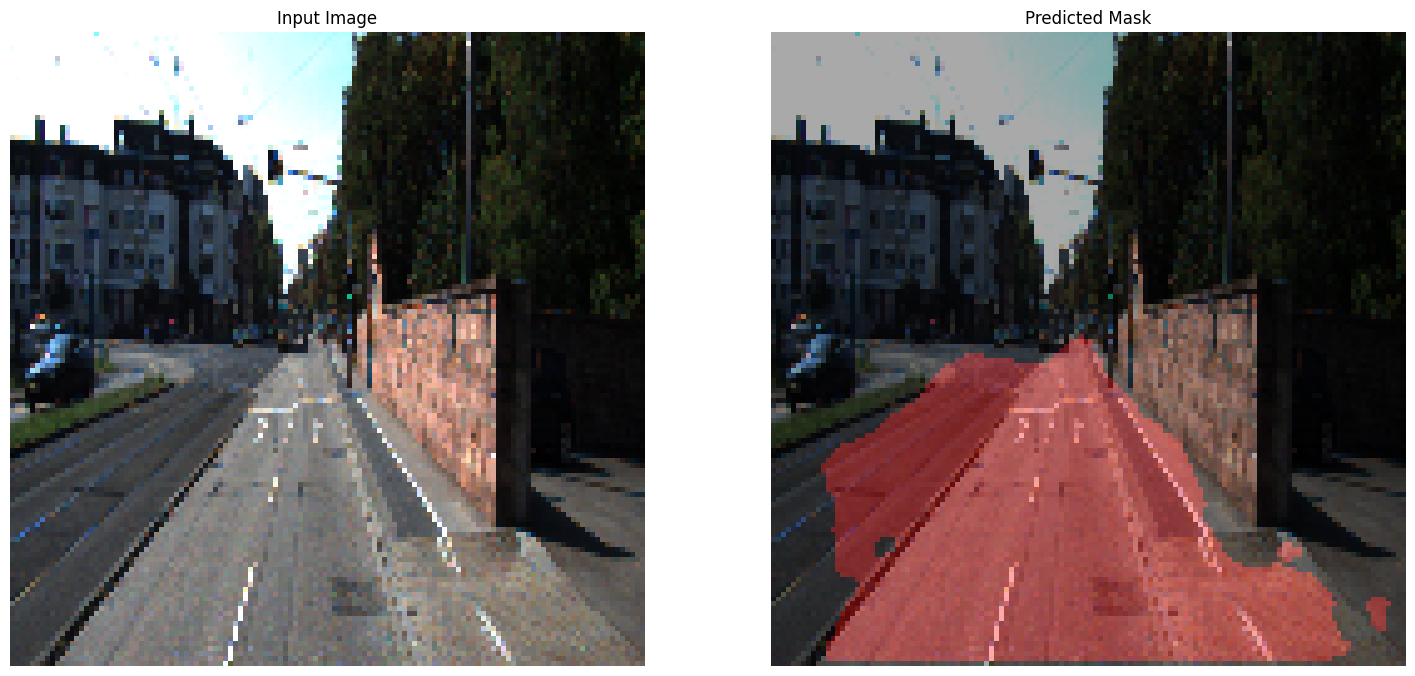

Processing image : 1
1/1 [==============================] - 0s 32ms/step


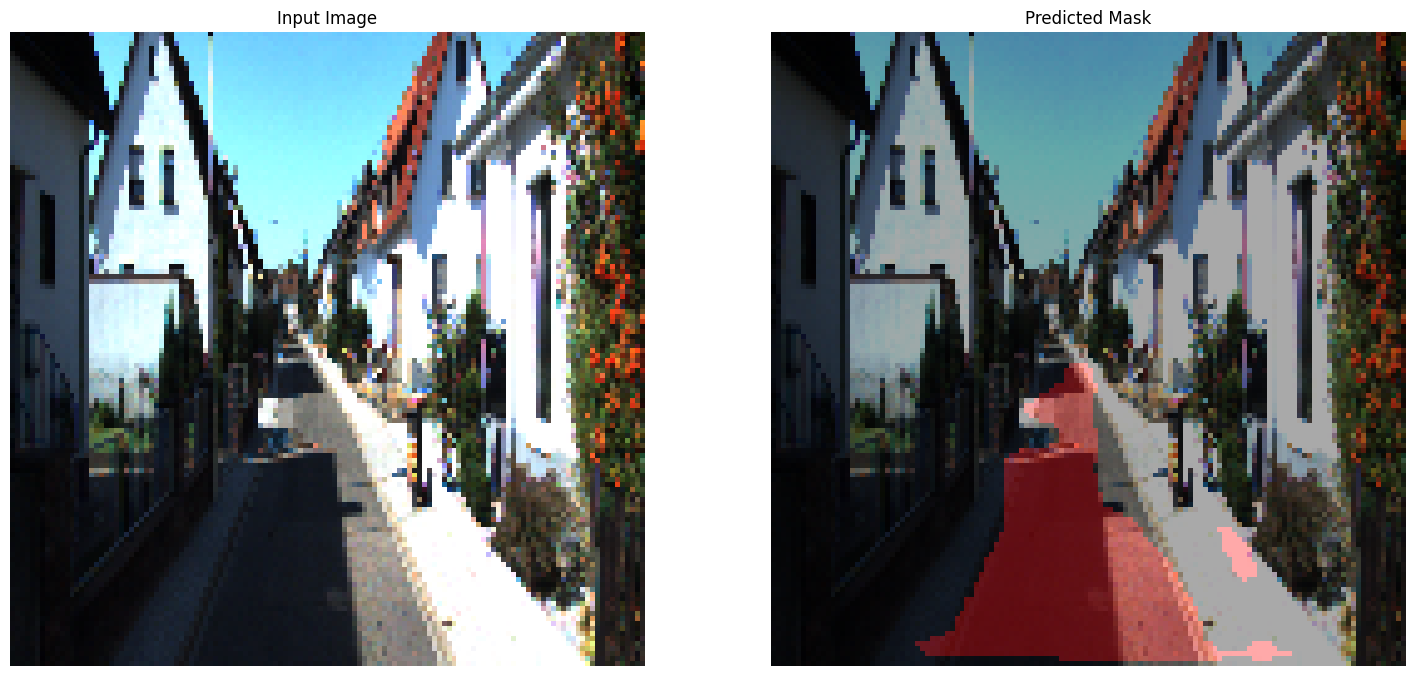

Processing image : 2
1/1 [==============================] - 0s 18ms/step


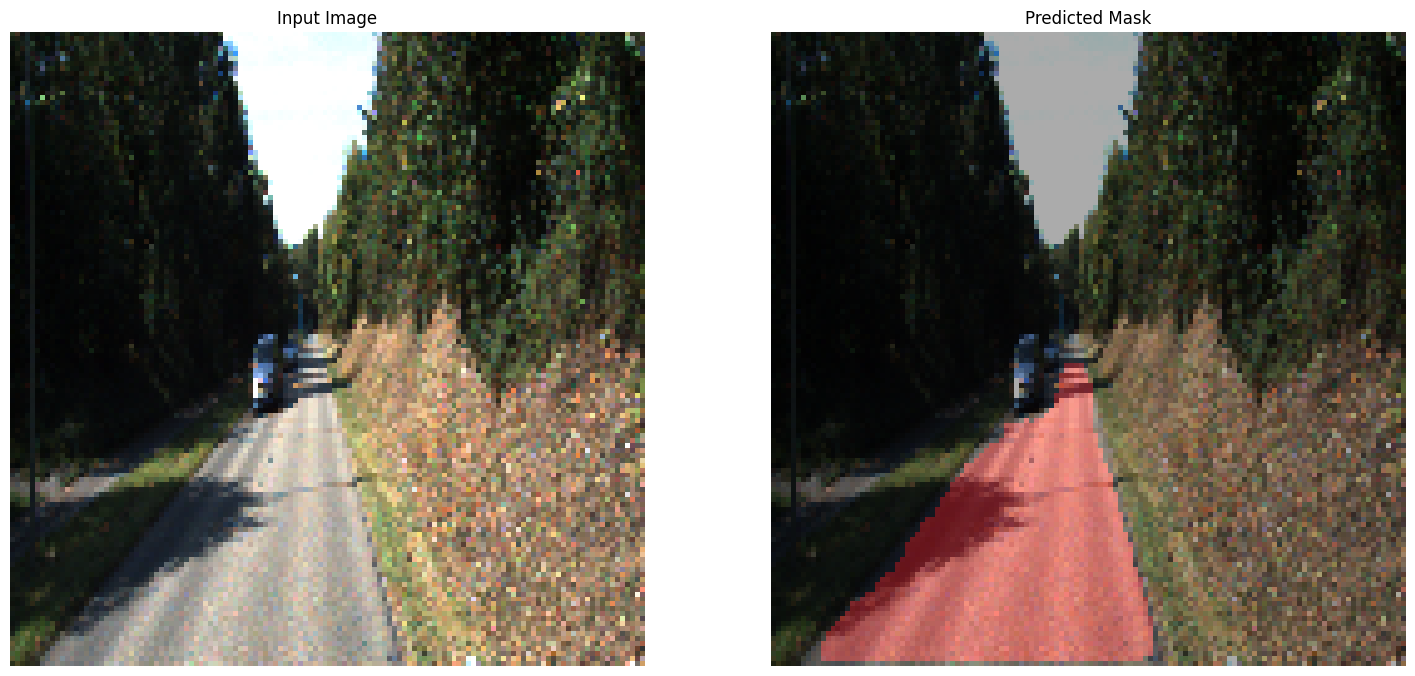

Processing image : 3
1/1 [==============================] - 0s 20ms/step


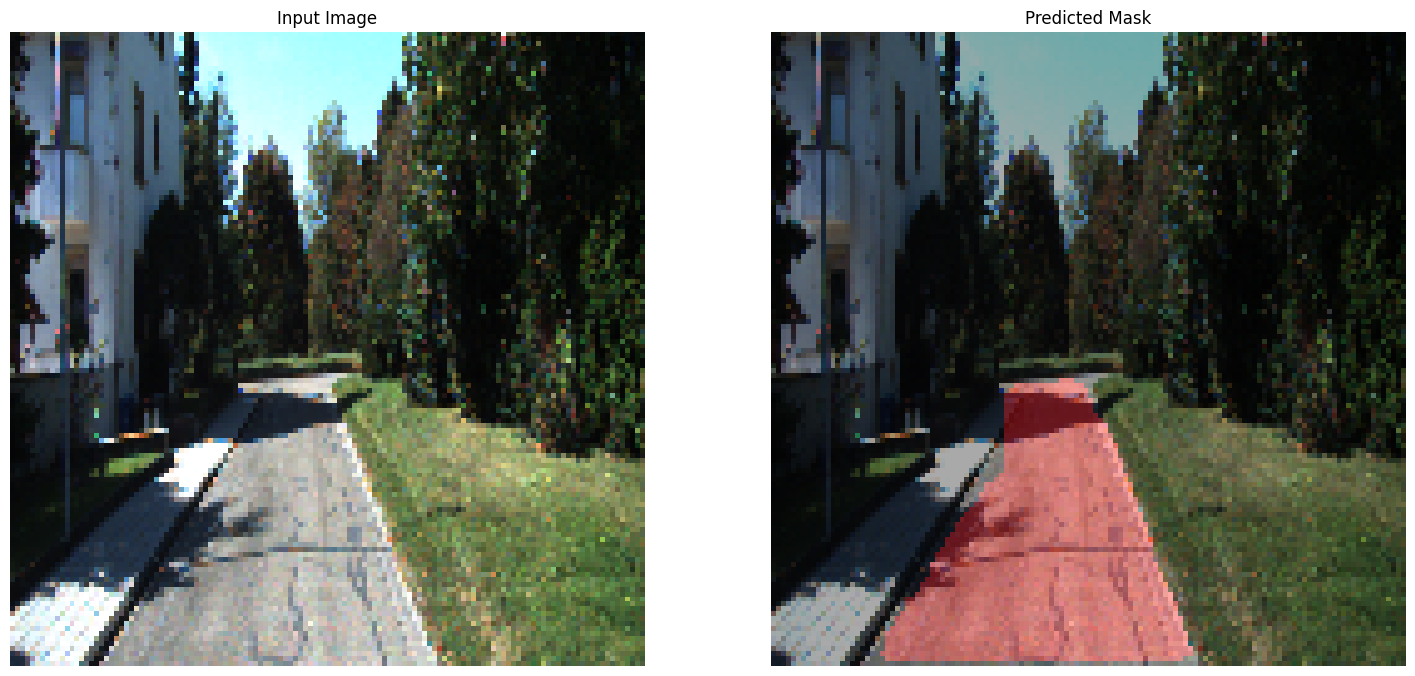

Processing image : 4
1/1 [==============================] - 0s 18ms/step


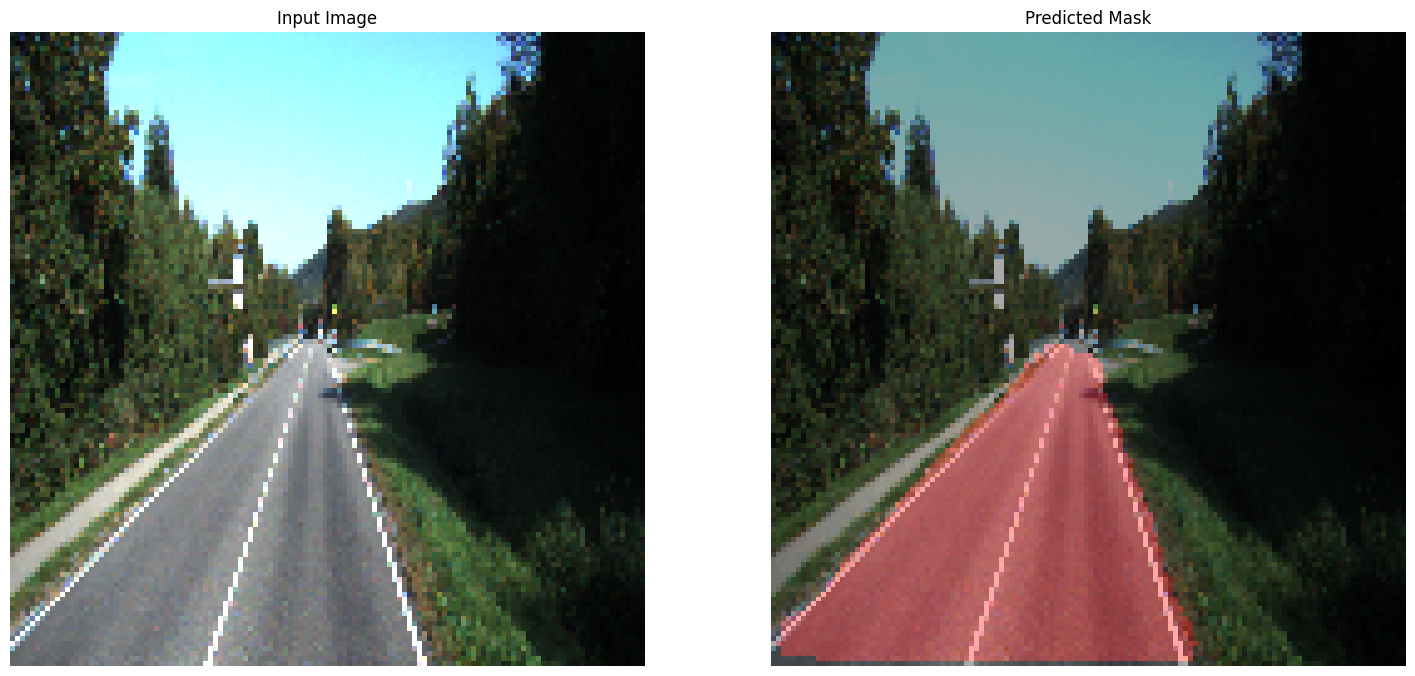

Processing image : 5
1/1 [==============================] - 0s 19ms/step


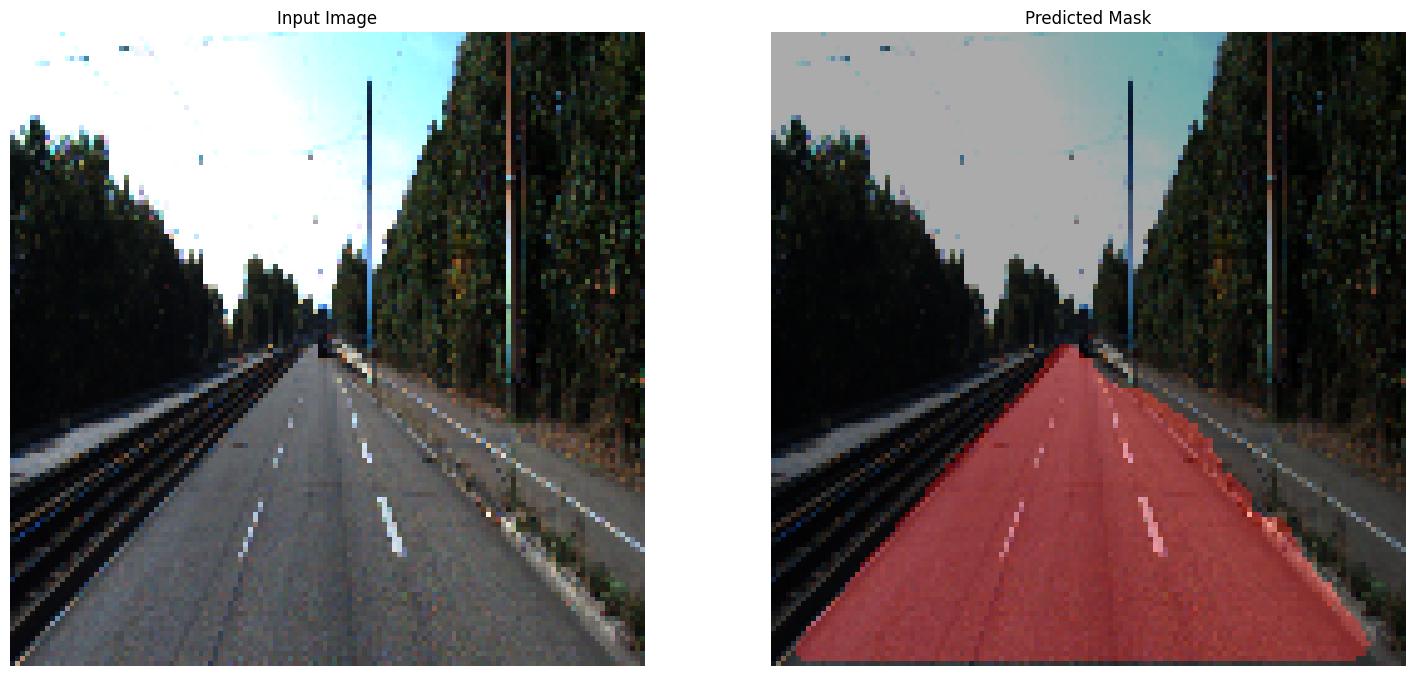

Processing image : 6
1/1 [==============================] - 0s 18ms/step


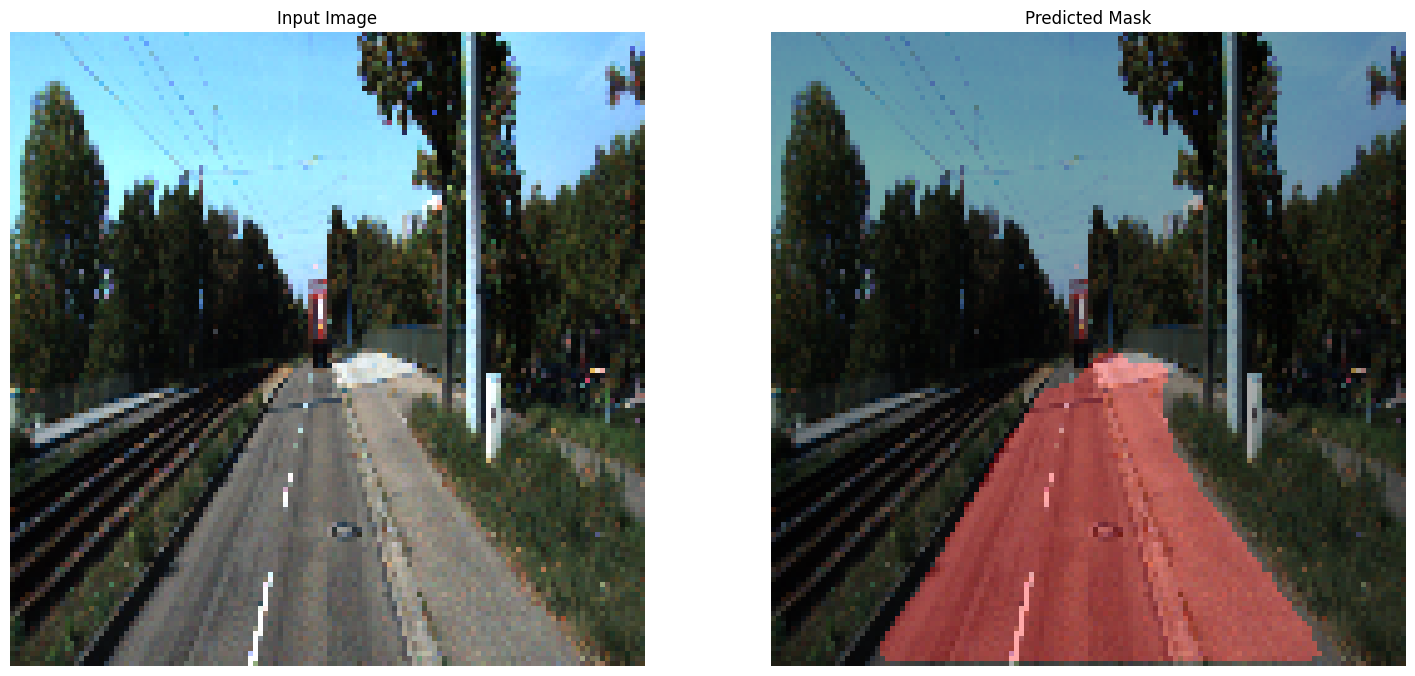

Processing image : 7
1/1 [==============================] - 0s 18ms/step


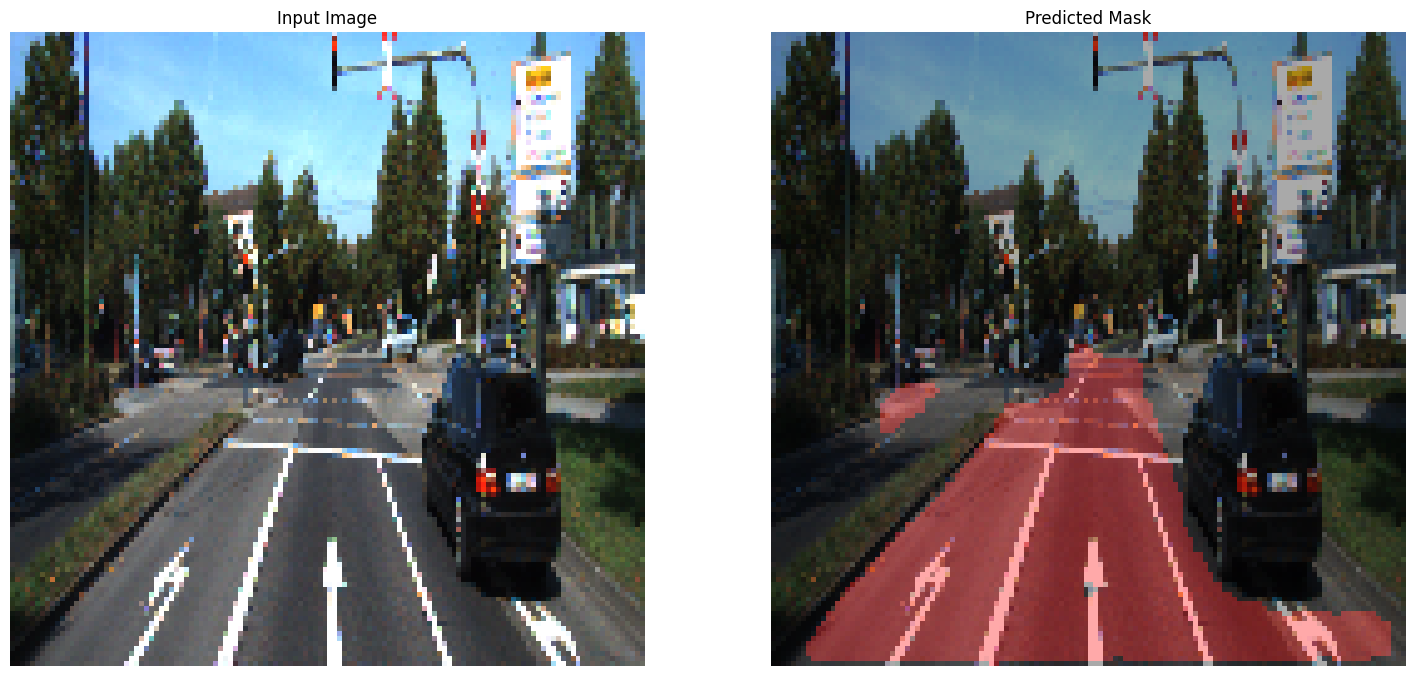

Processing image : 8
1/1 [==============================] - 0s 19ms/step


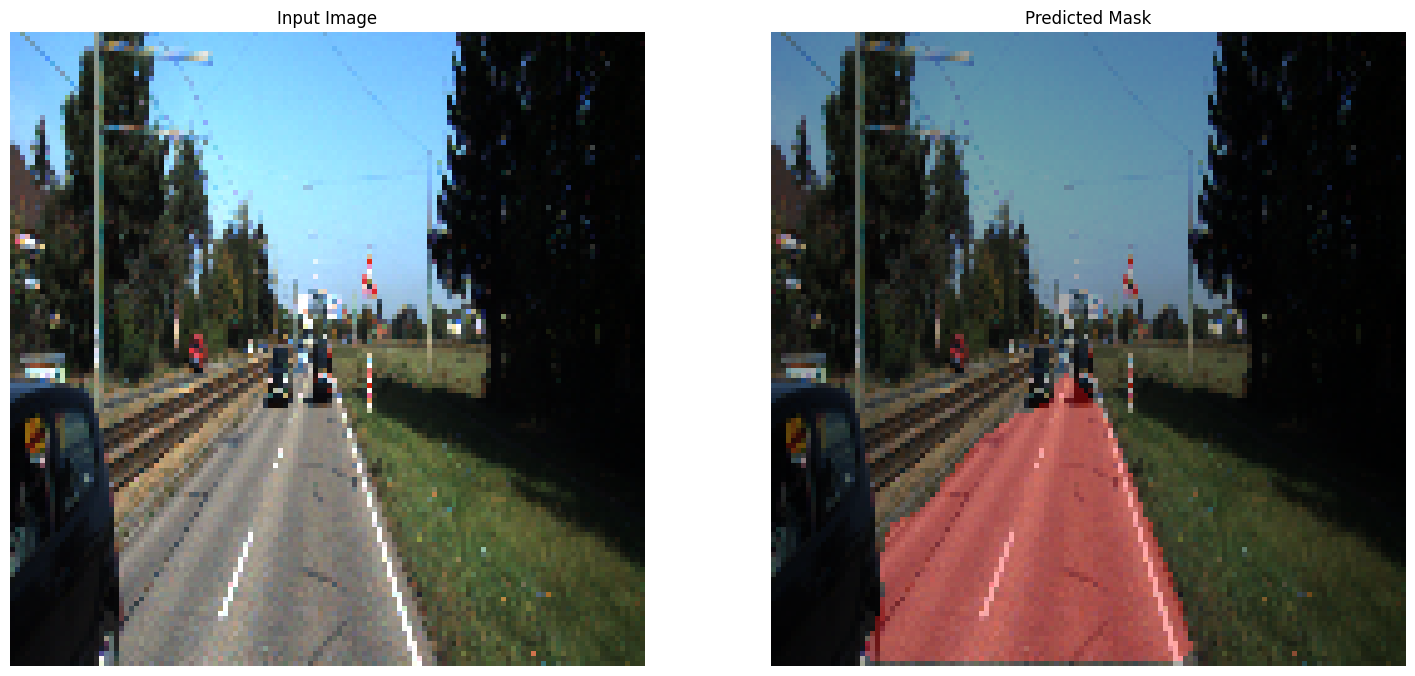

Processing image : 9
1/1 [==============================] - 0s 19ms/step


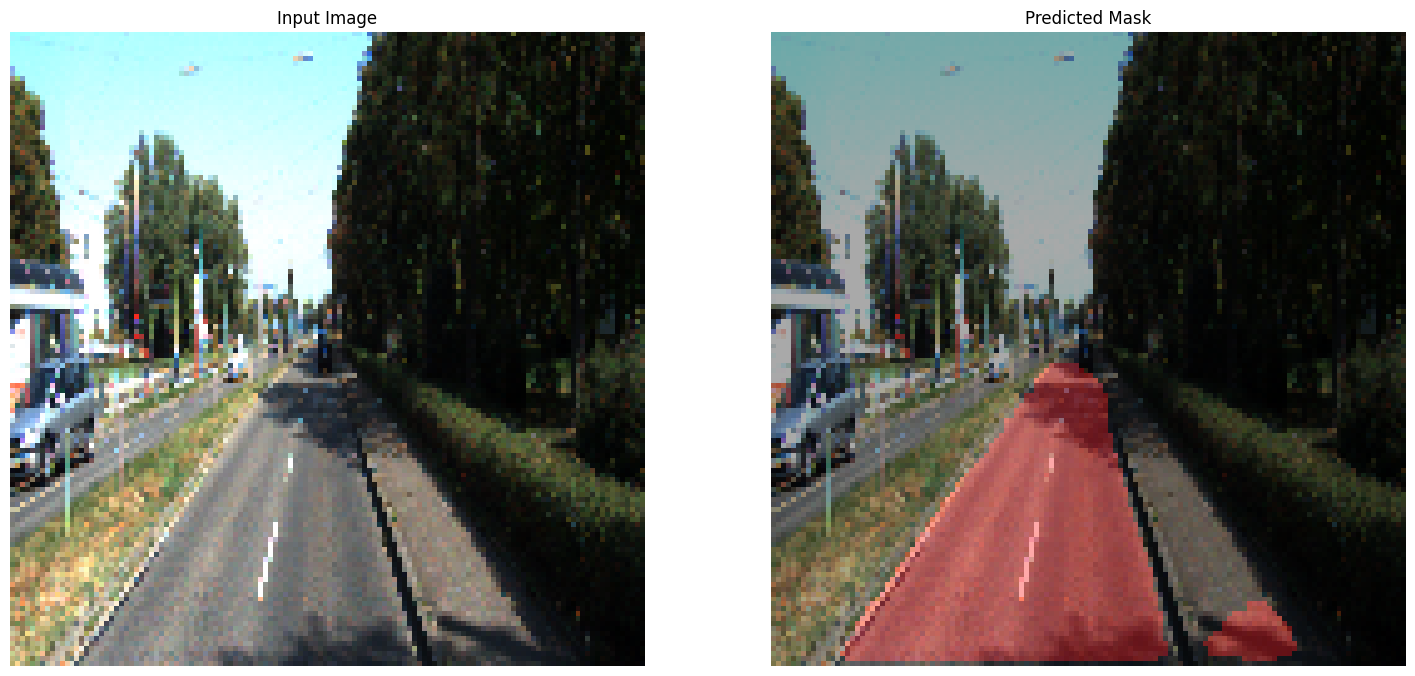

Processing image : 10
1/1 [==============================] - 0s 40ms/step


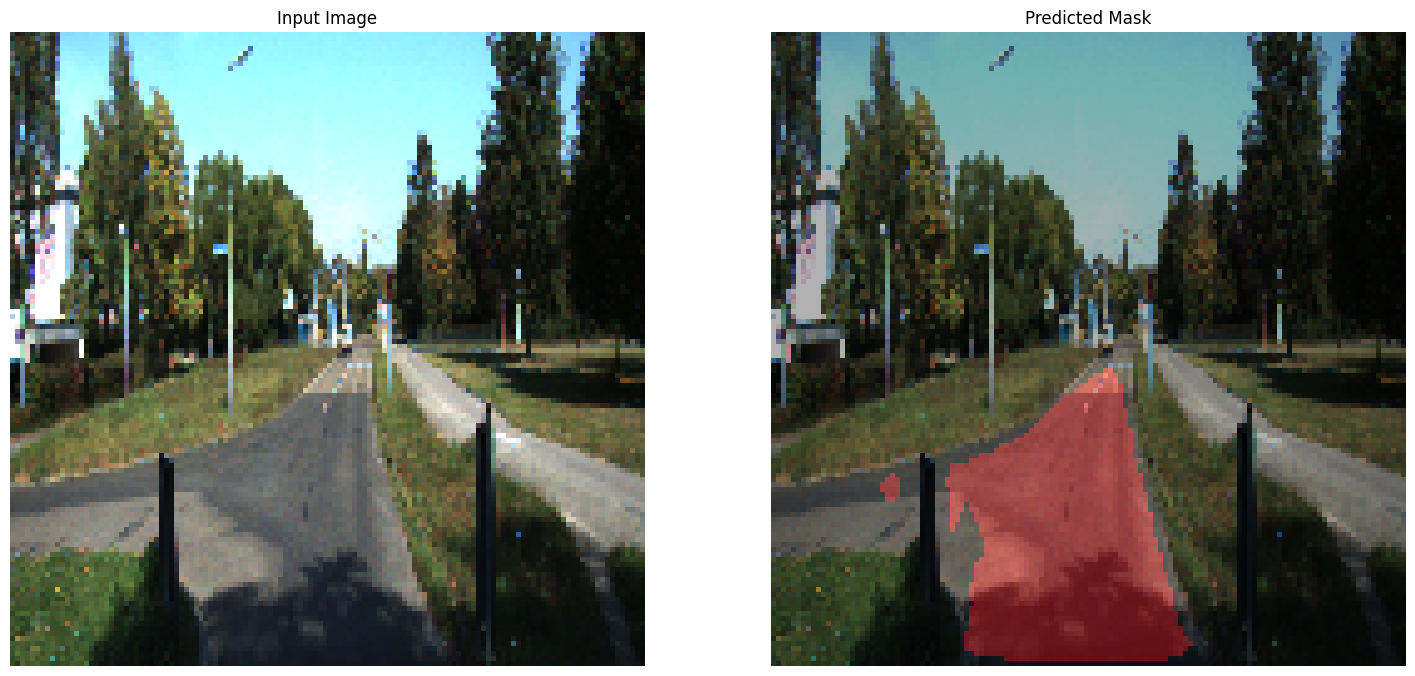

Processing image : 11
1/1 [==============================] - 0s 28ms/step


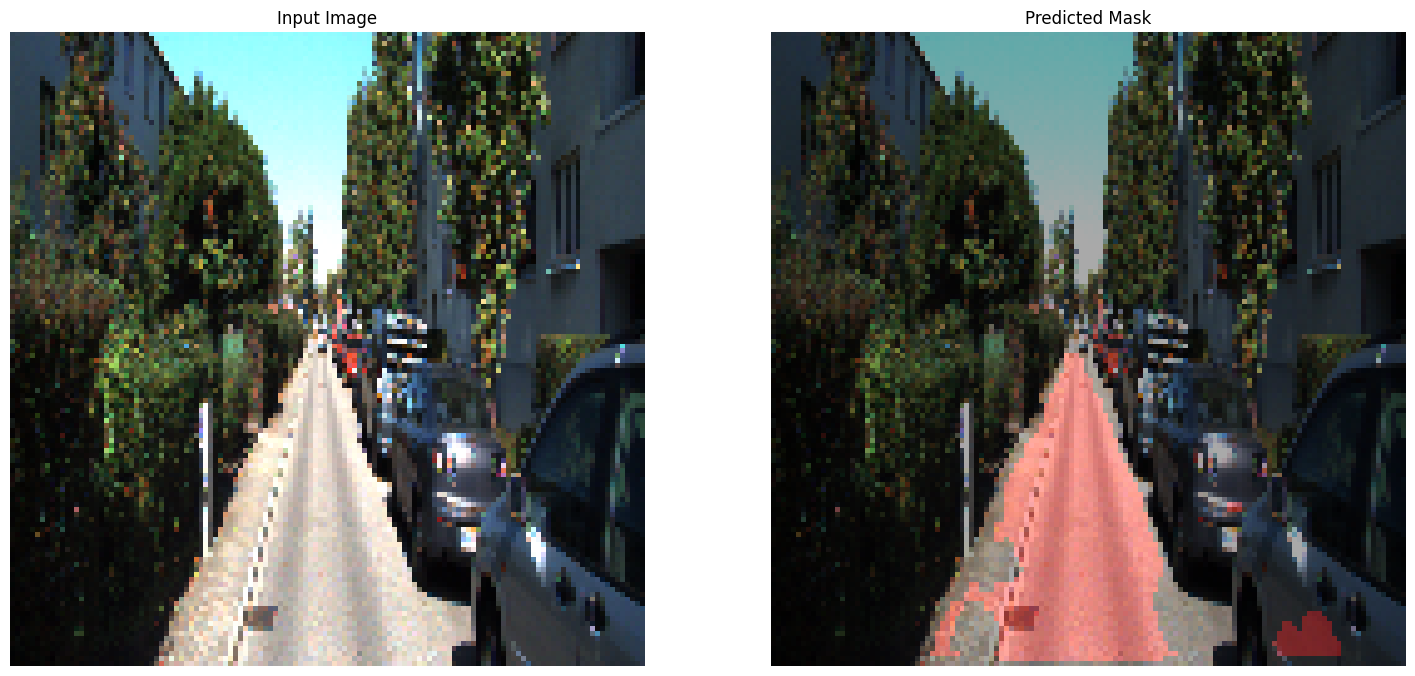

Processing image : 12
1/1 [==============================] - 0s 30ms/step


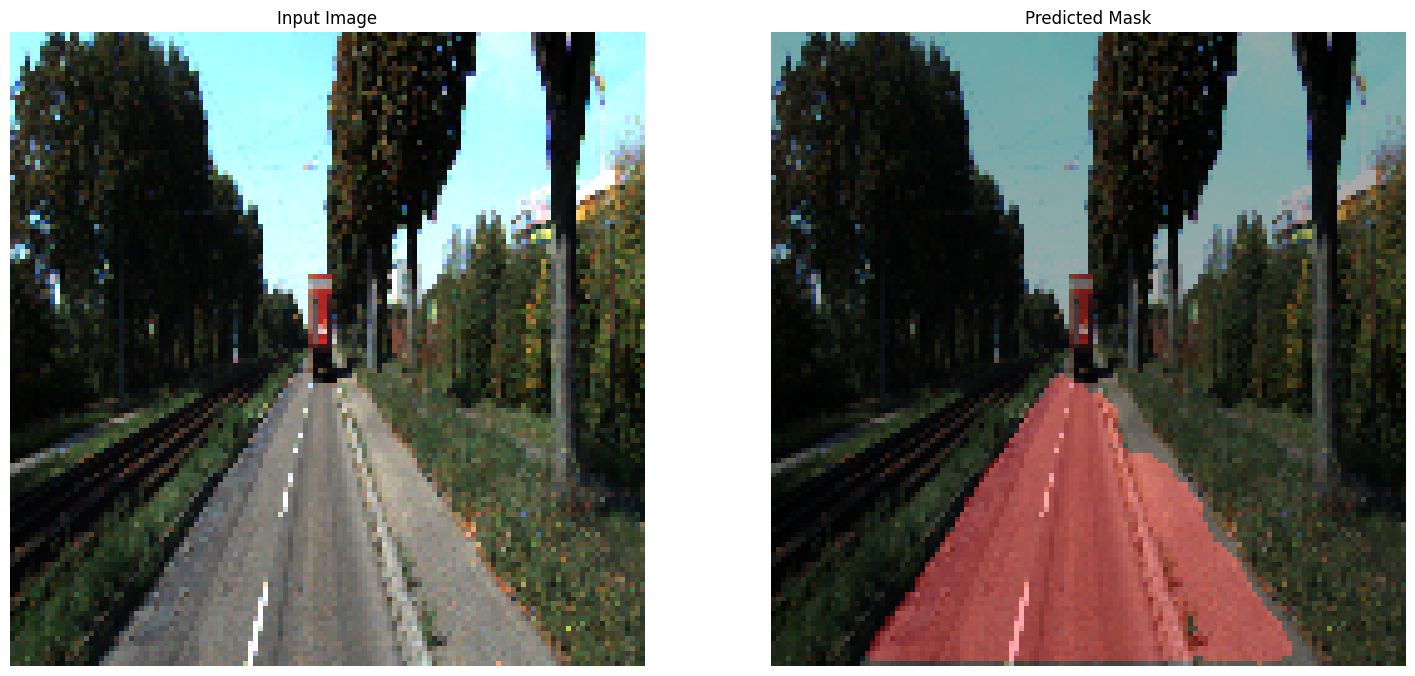

Processing image : 13
1/1 [==============================] - 0s 20ms/step


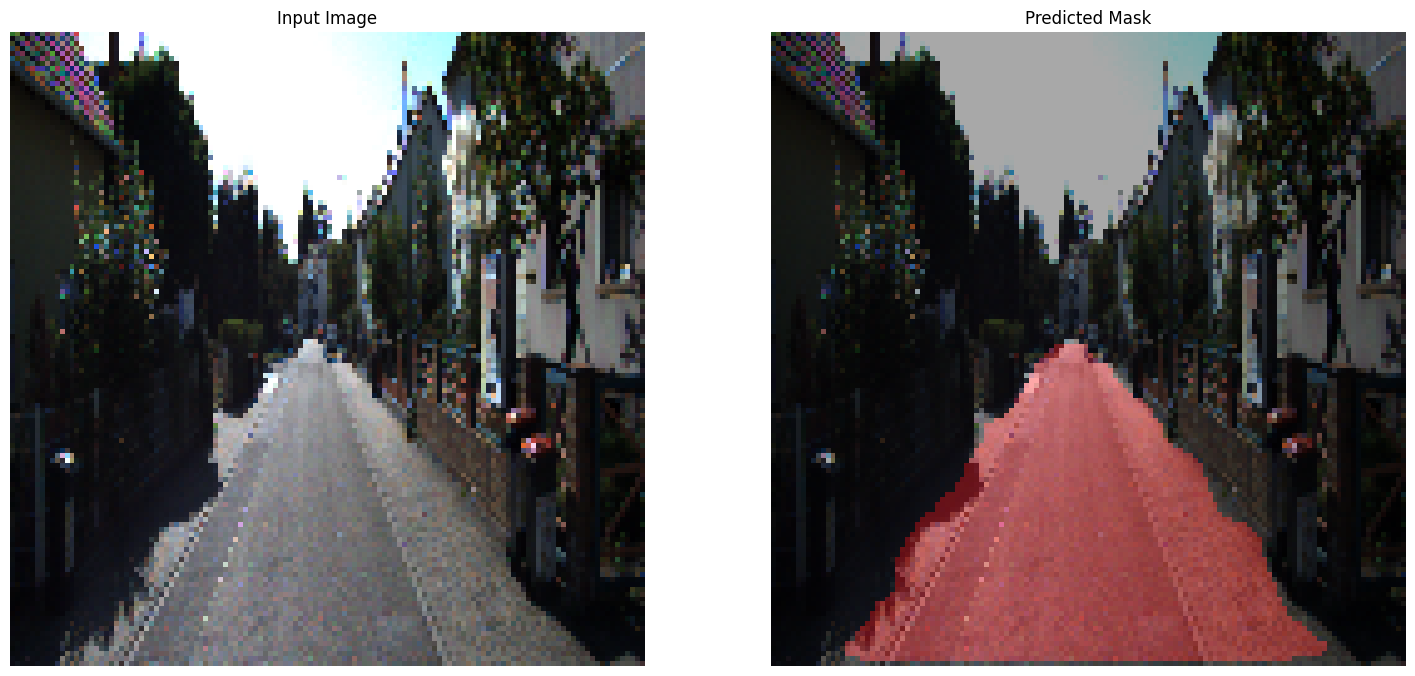

Processing image : 14
1/1 [==============================] - 0s 19ms/step


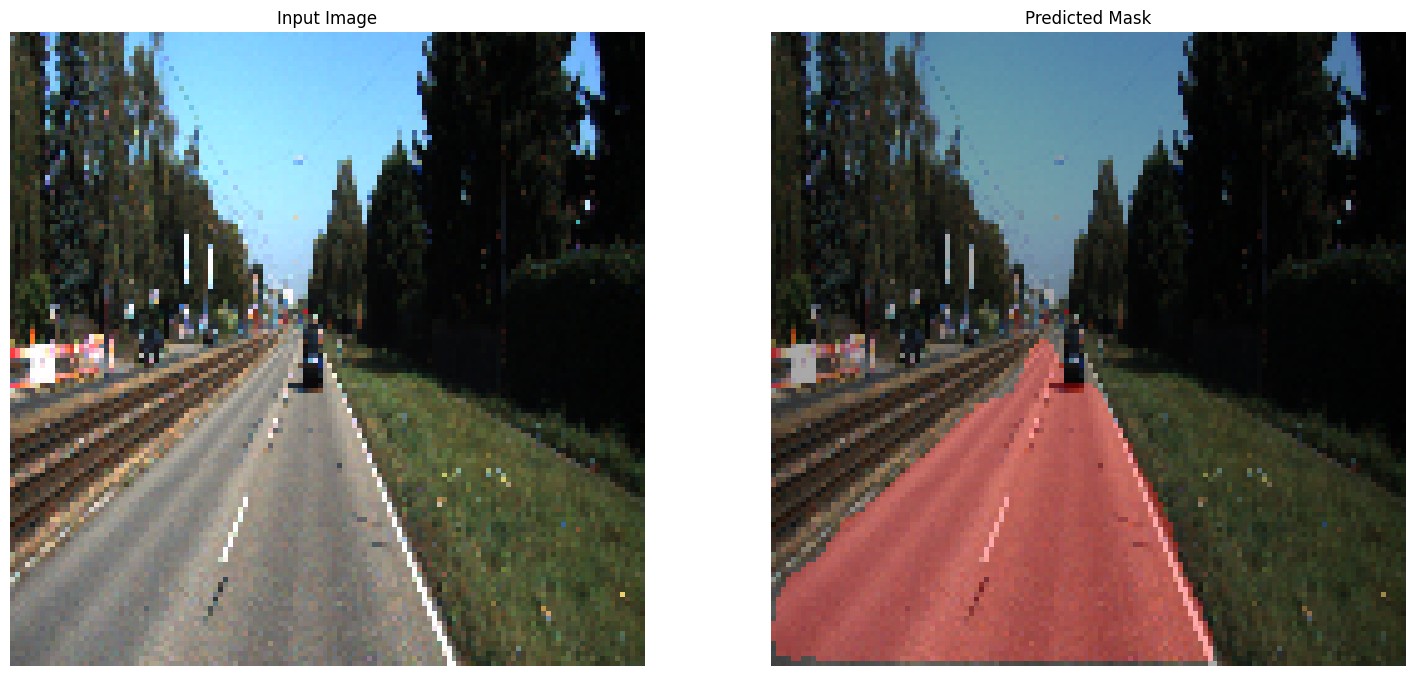

Processing image : 15
1/1 [==============================] - 0s 24ms/step


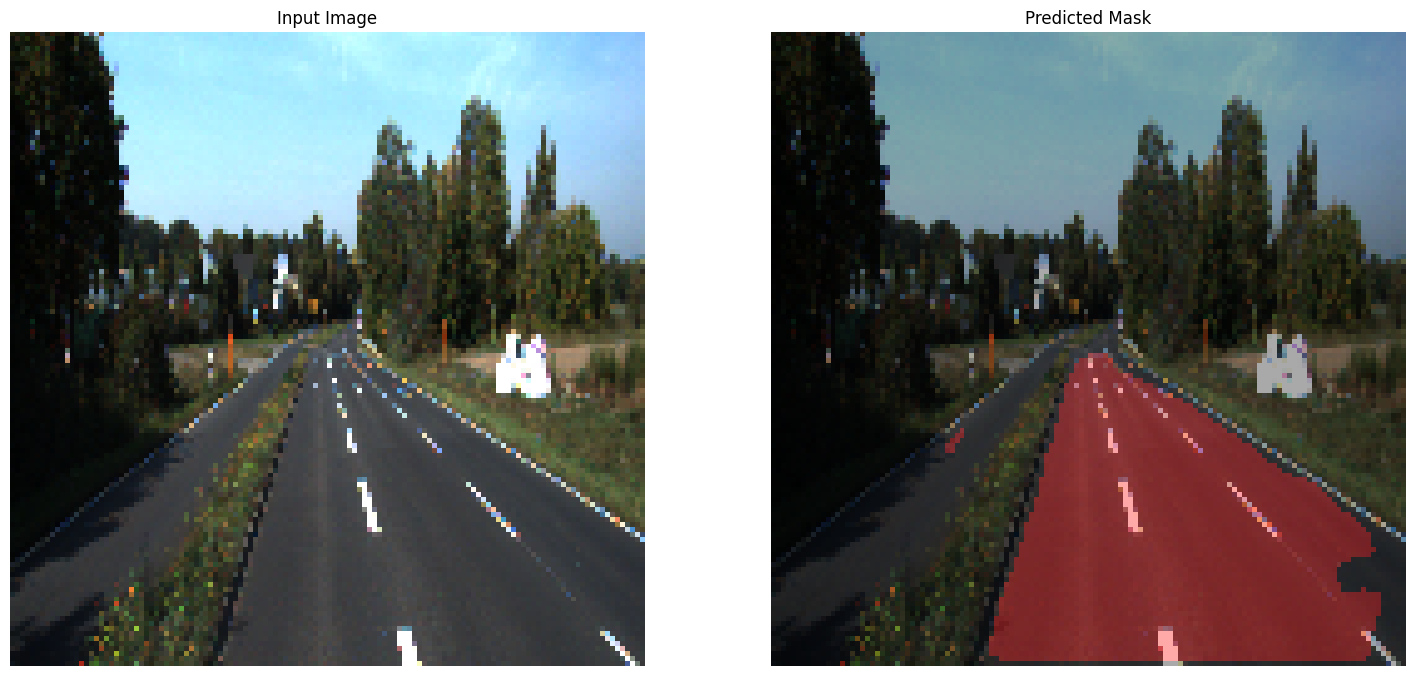

Processing image : 16
1/1 [==============================] - 0s 25ms/step


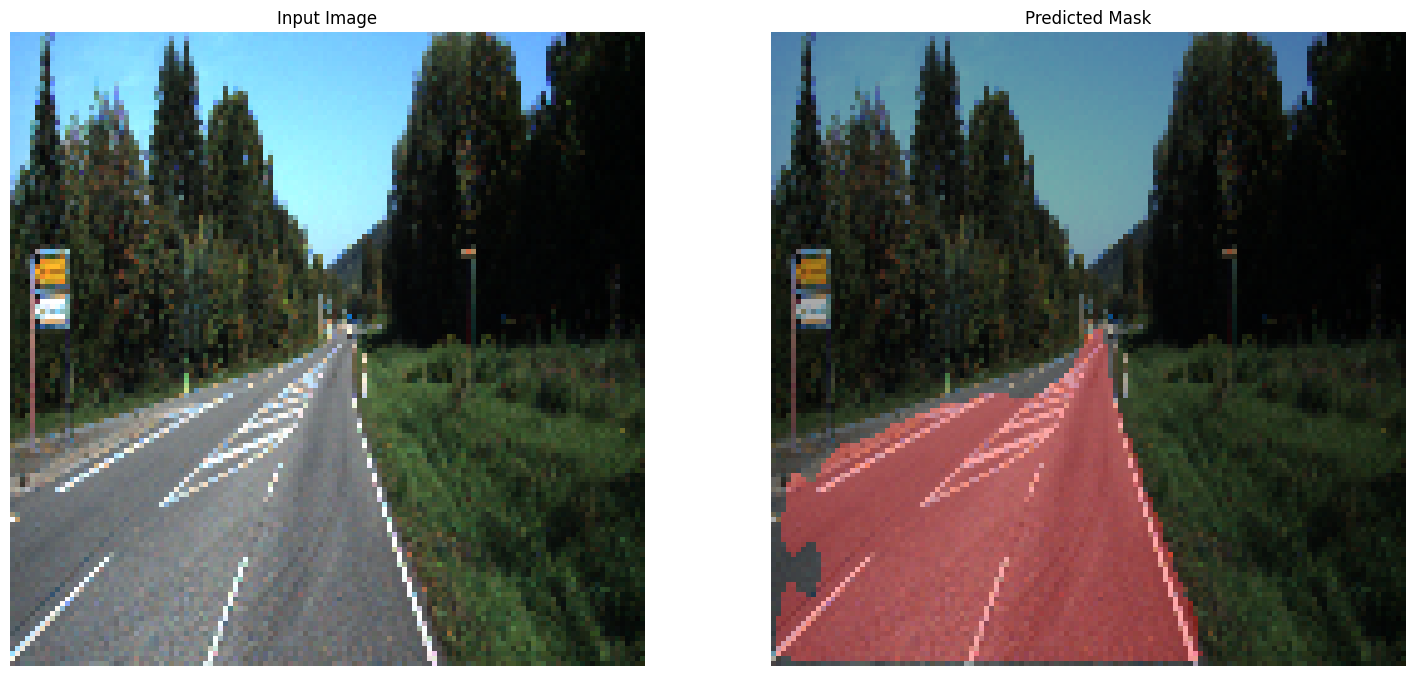

Processing image : 17
1/1 [==============================] - 0s 29ms/step


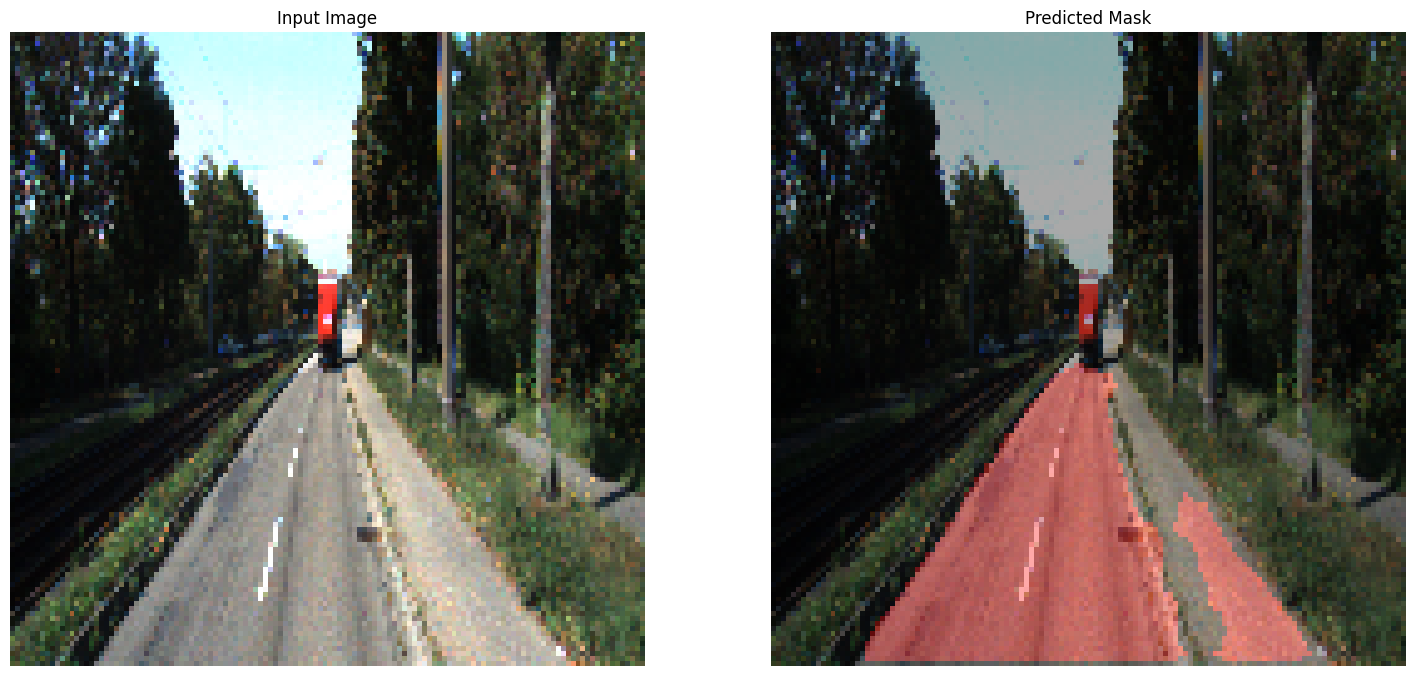

Processing image : 18
1/1 [==============================] - 0s 27ms/step


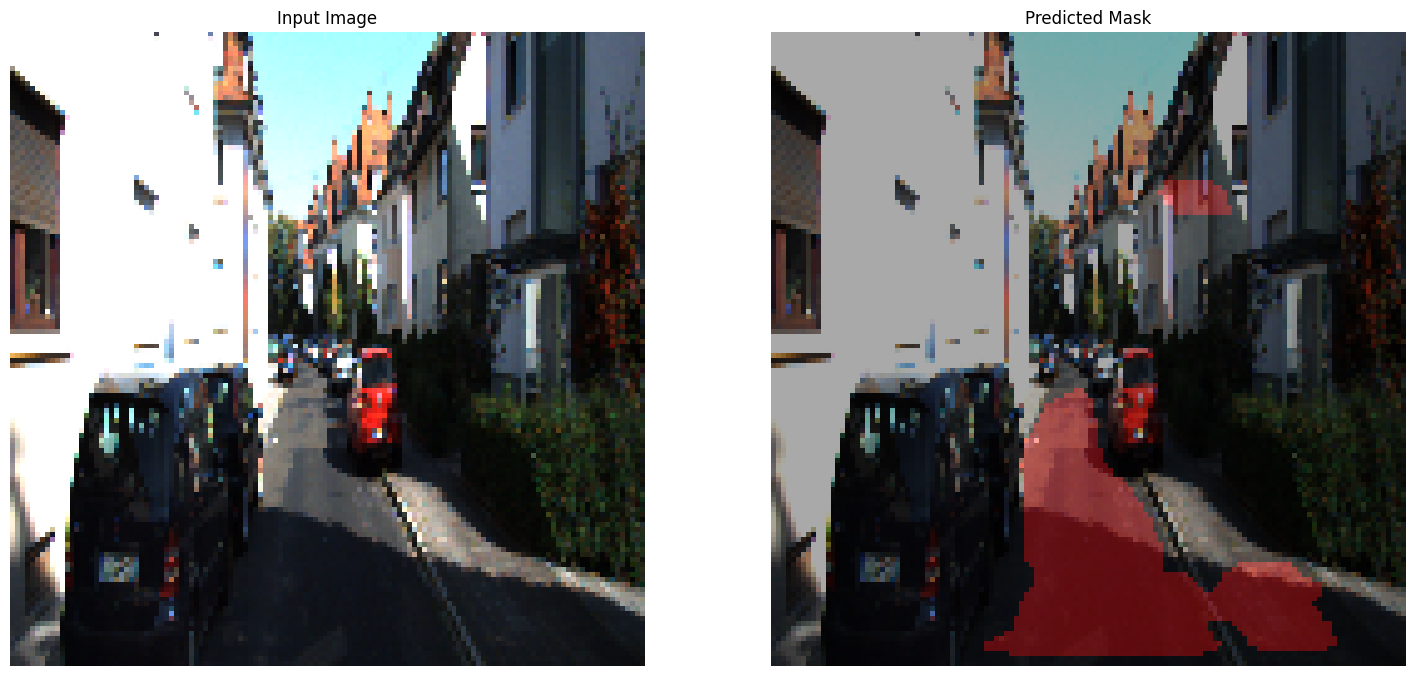

Processing image : 19
1/1 [==============================] - 0s 26ms/step


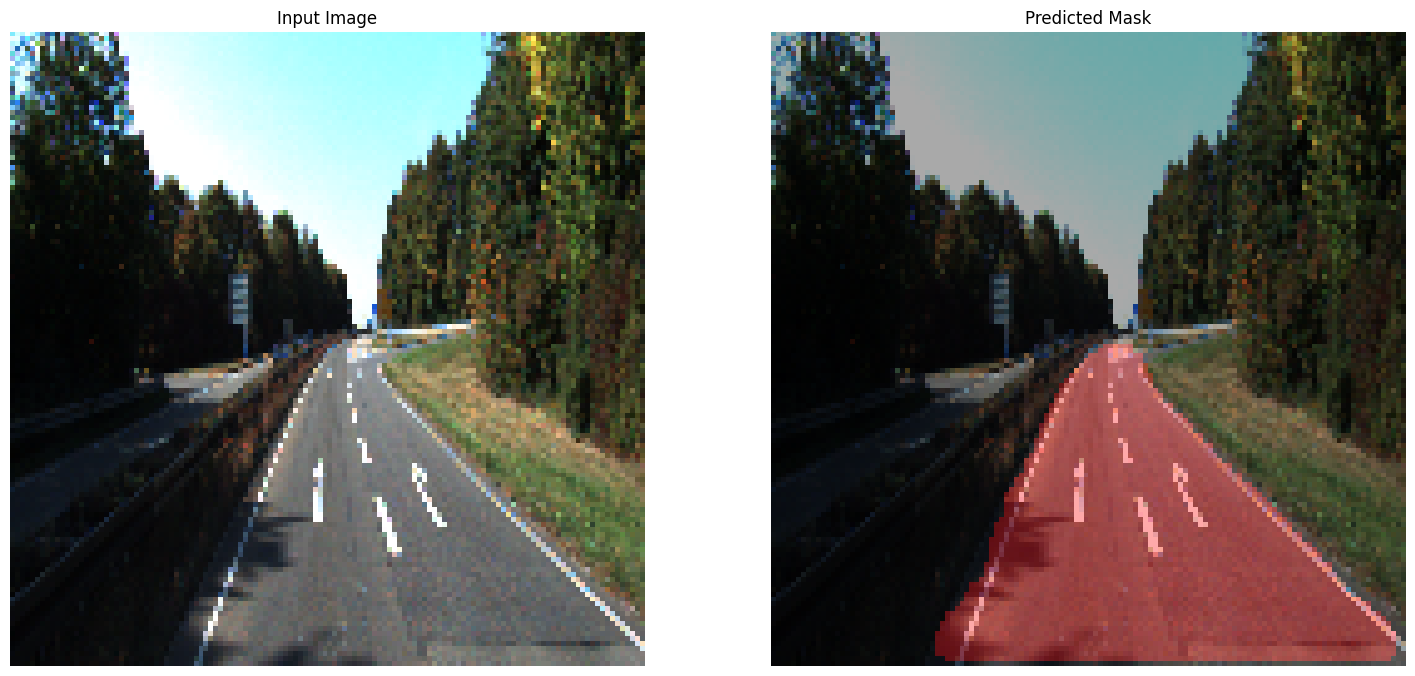

Processing image : 20
1/1 [==============================] - 0s 23ms/step


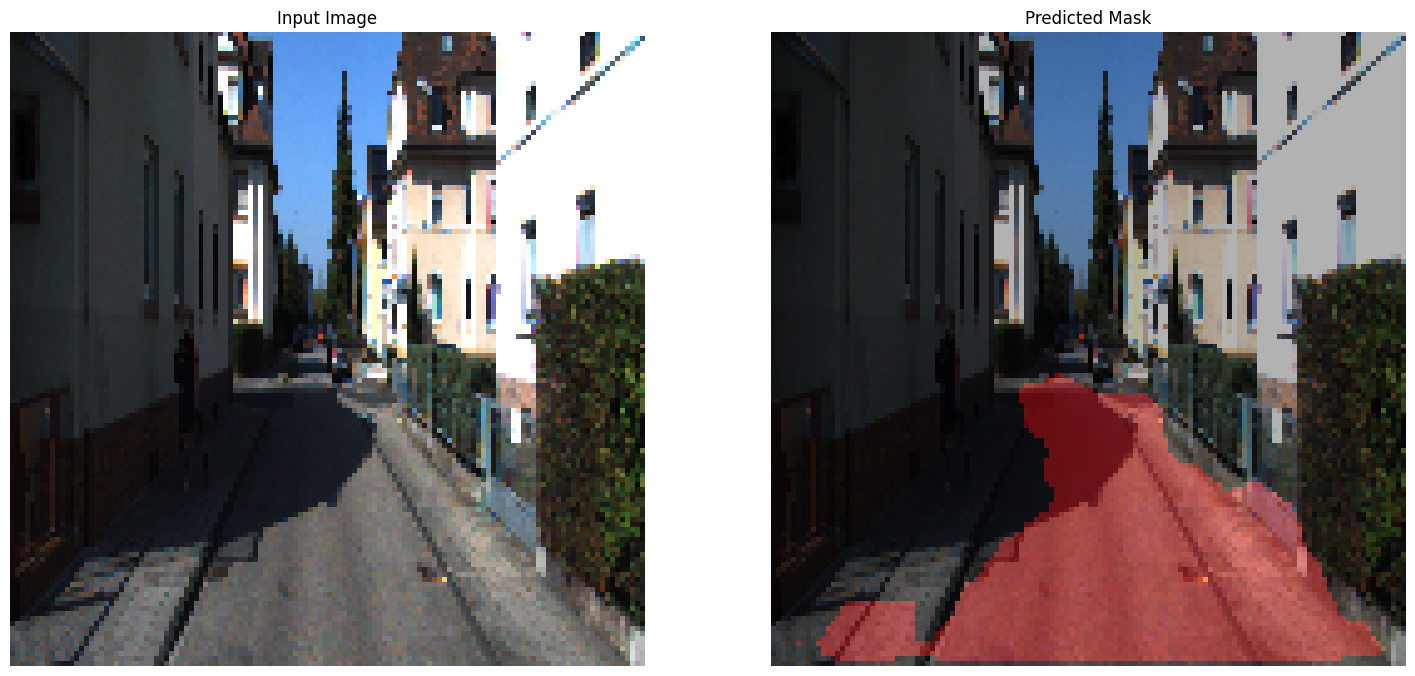

Processing image : 21
1/1 [==============================] - 0s 34ms/step


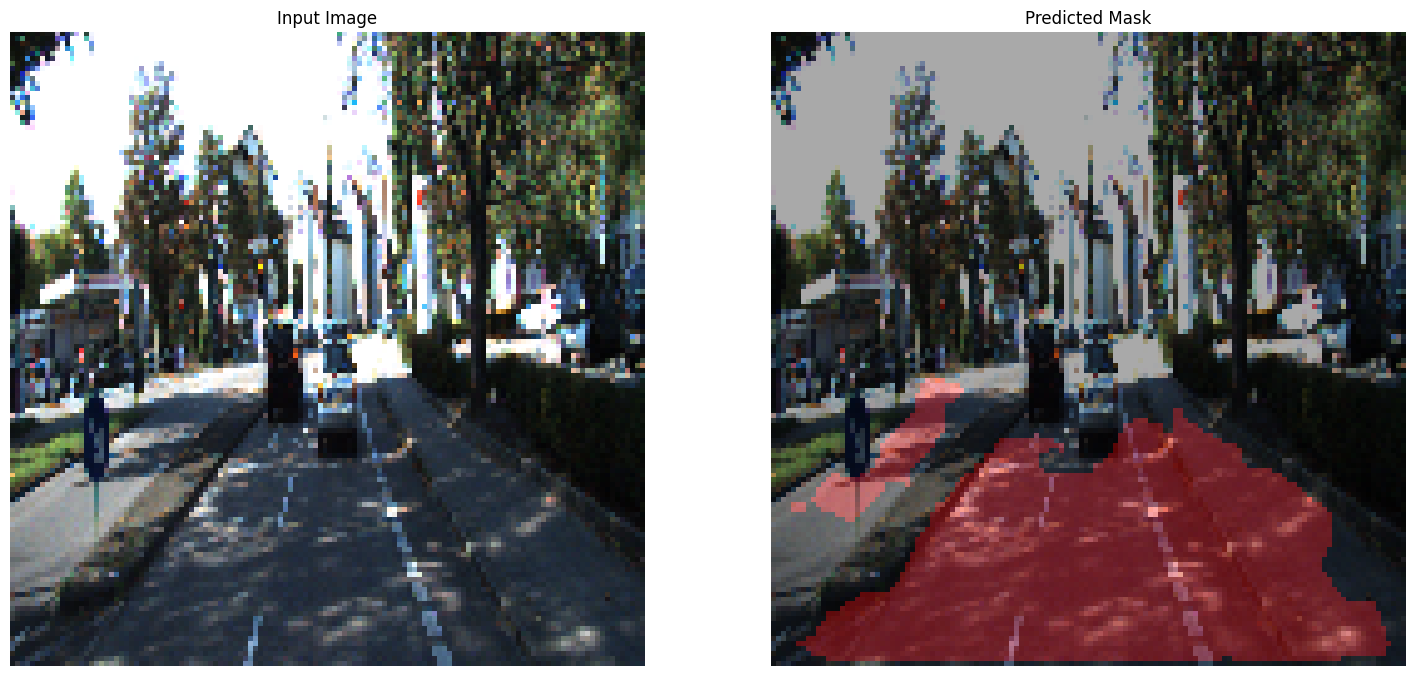

Processing image : 22
1/1 [==============================] - 0s 45ms/step


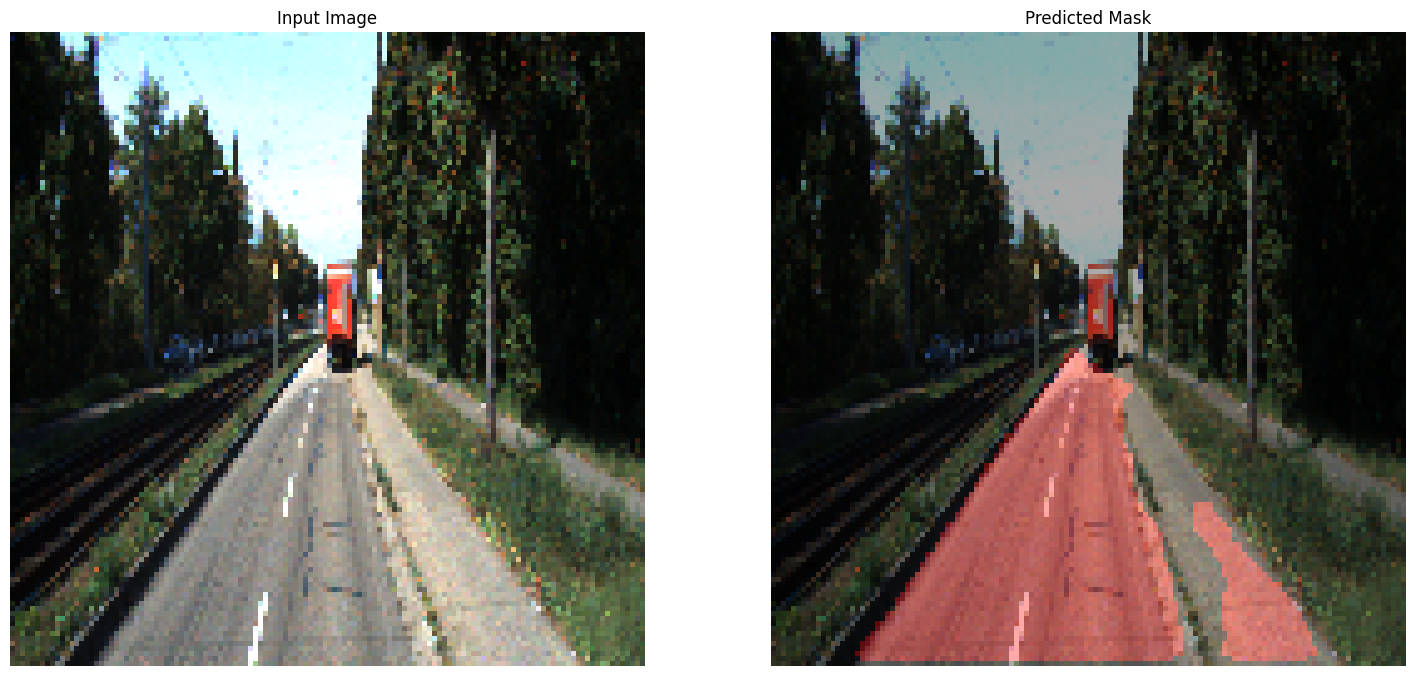

Processing image : 23
1/1 [==============================] - 0s 26ms/step


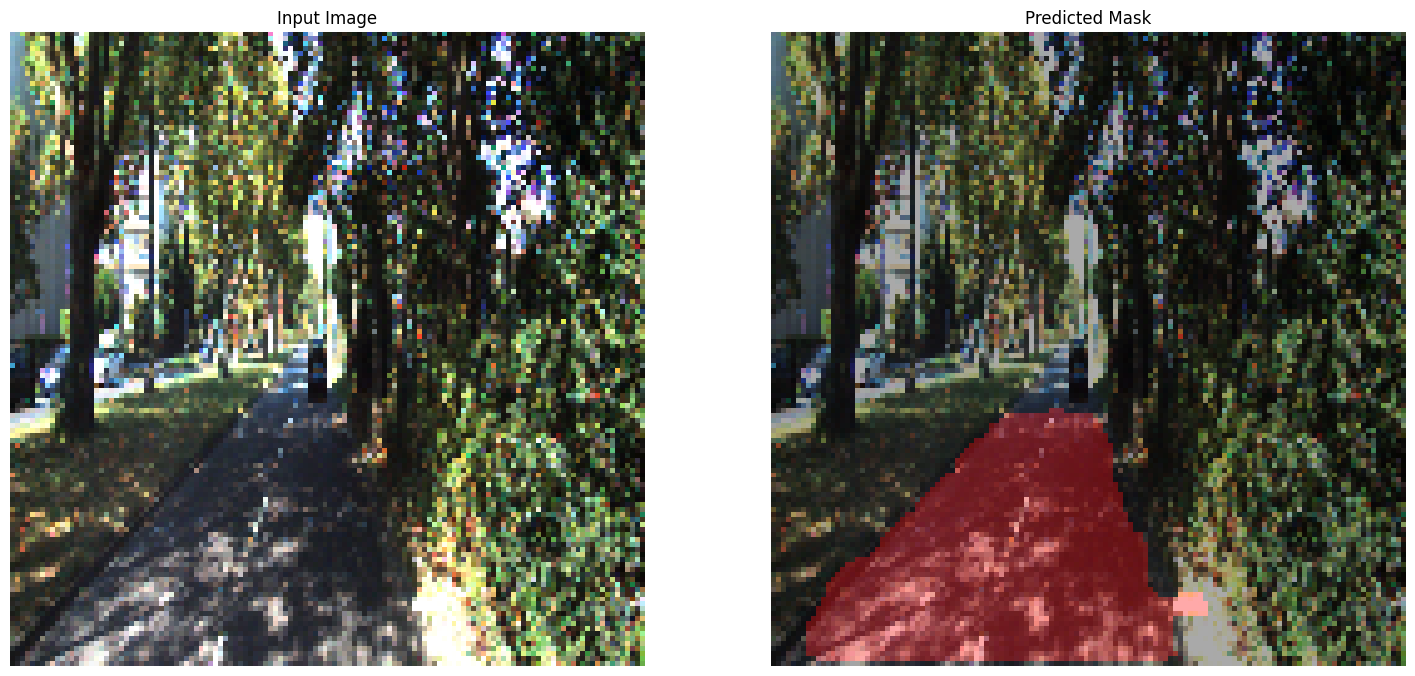

Processing image : 24
1/1 [==============================] - 0s 37ms/step


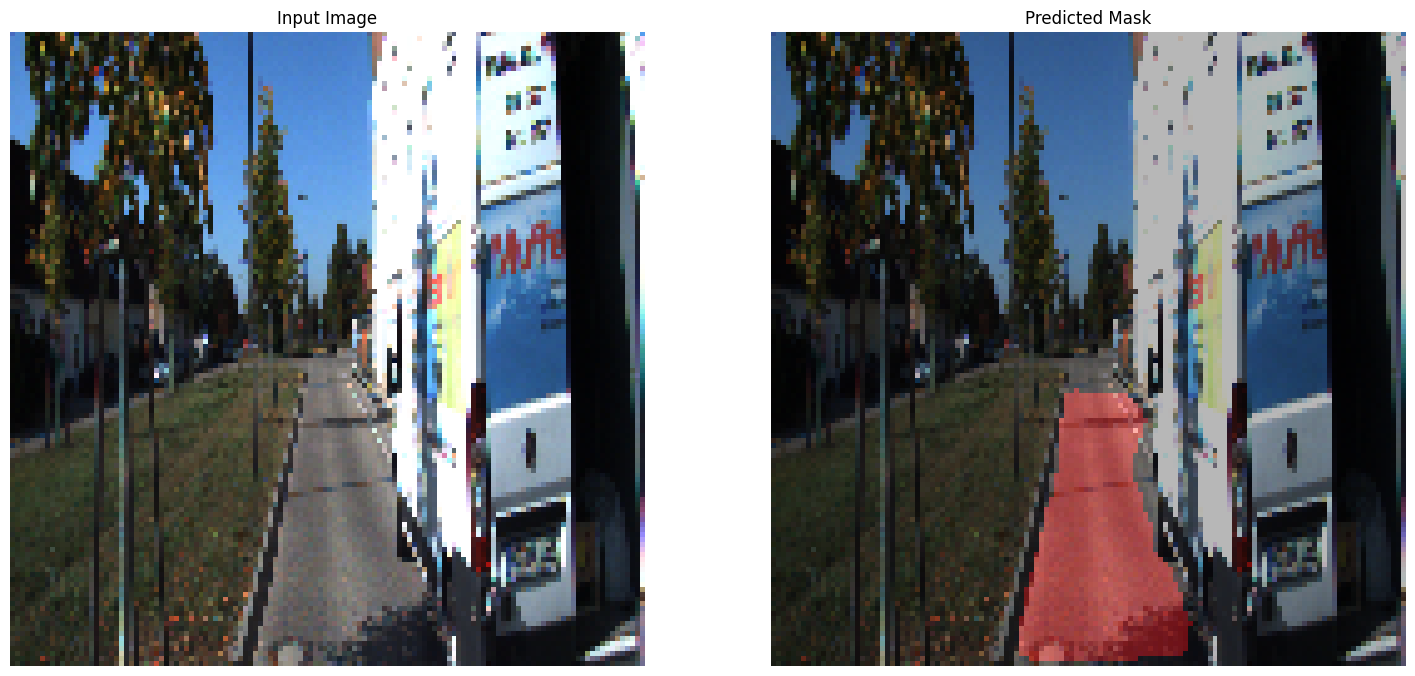

Processing image : 25
1/1 [==============================] - 0s 36ms/step


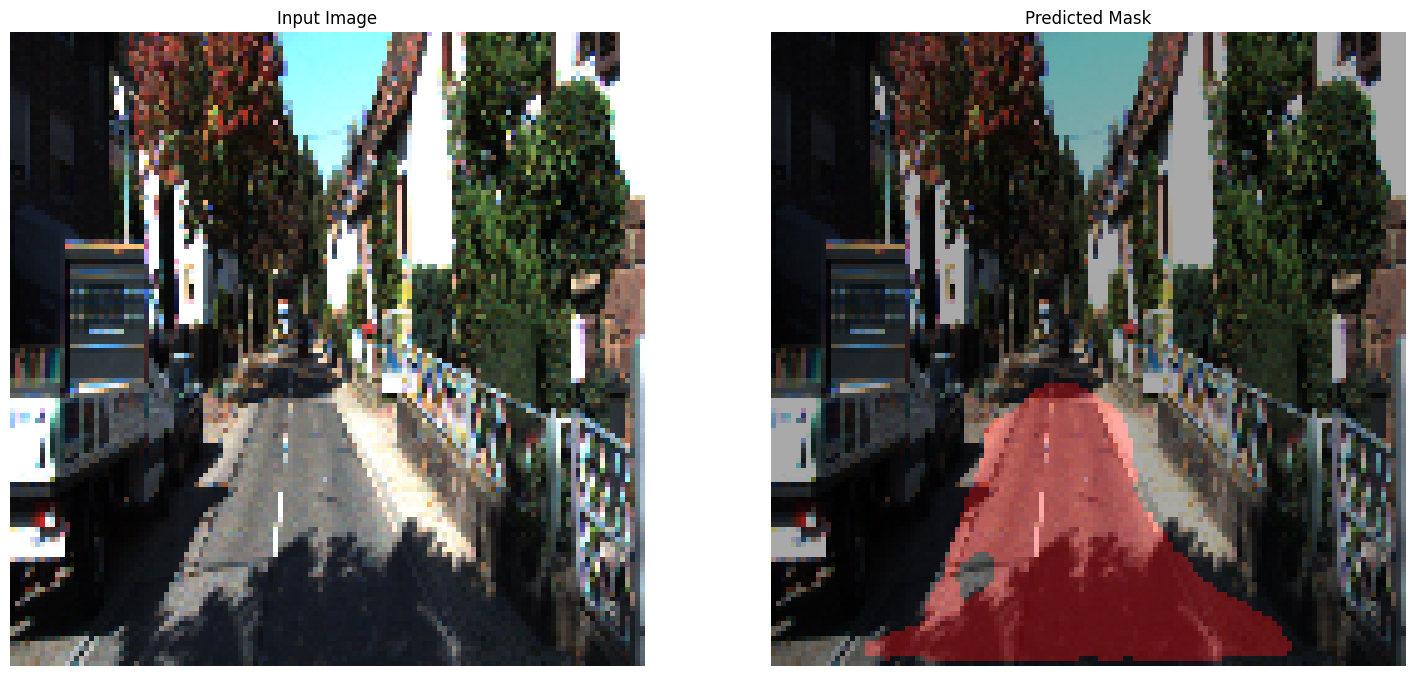

Processing image : 26
1/1 [==============================] - 0s 34ms/step


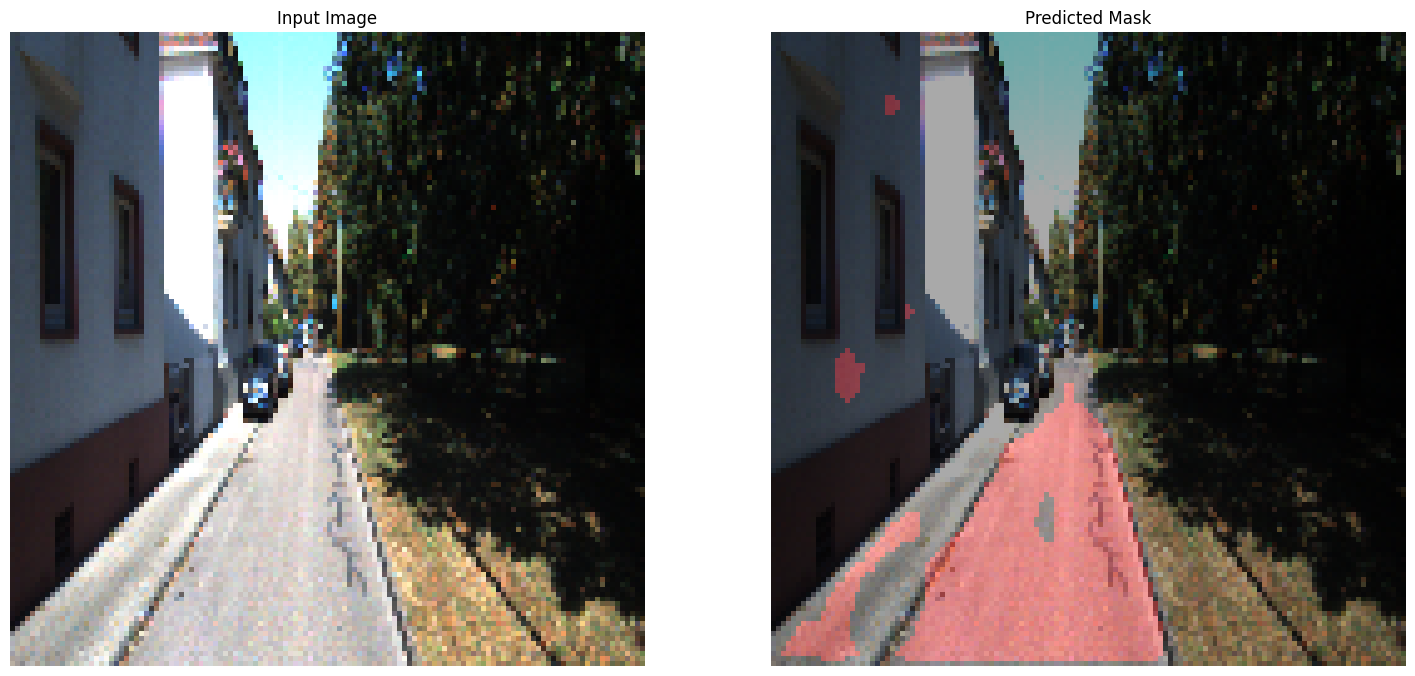

Processing image : 27
1/1 [==============================] - 0s 36ms/step


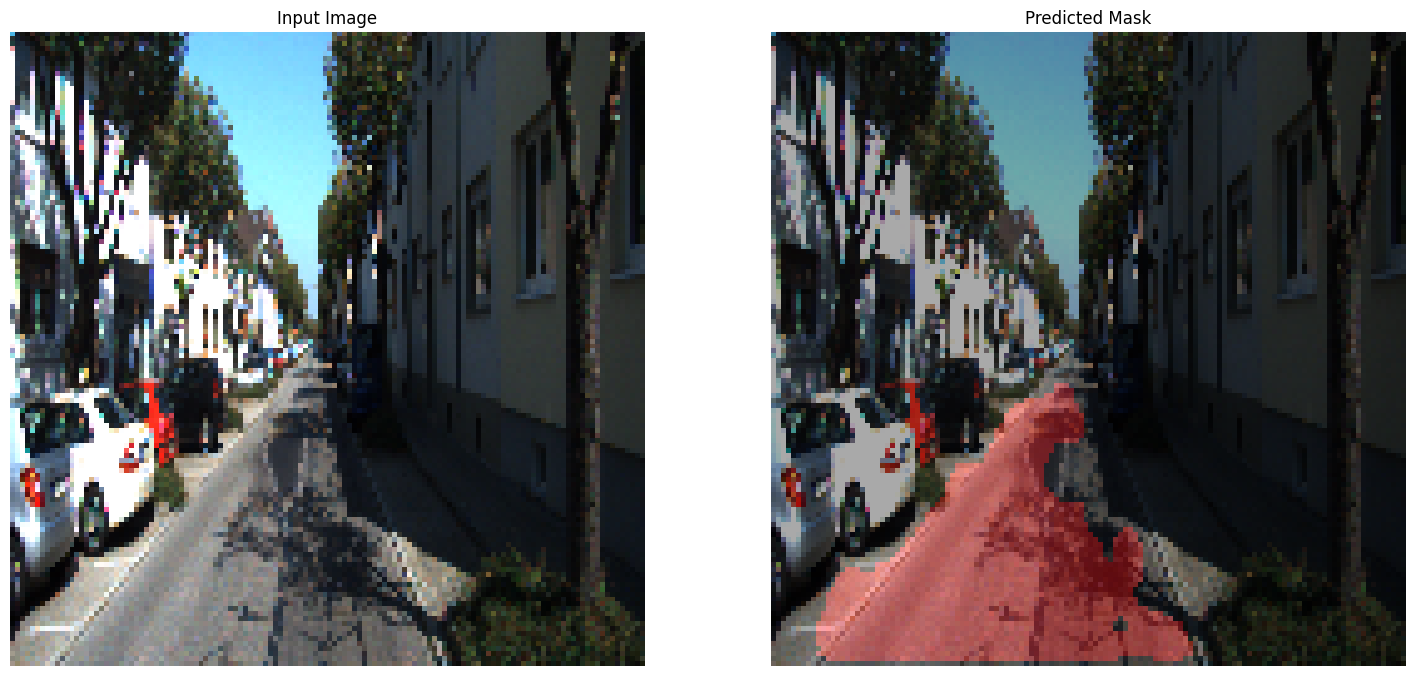

Processing image : 28
1/1 [==============================] - 0s 26ms/step


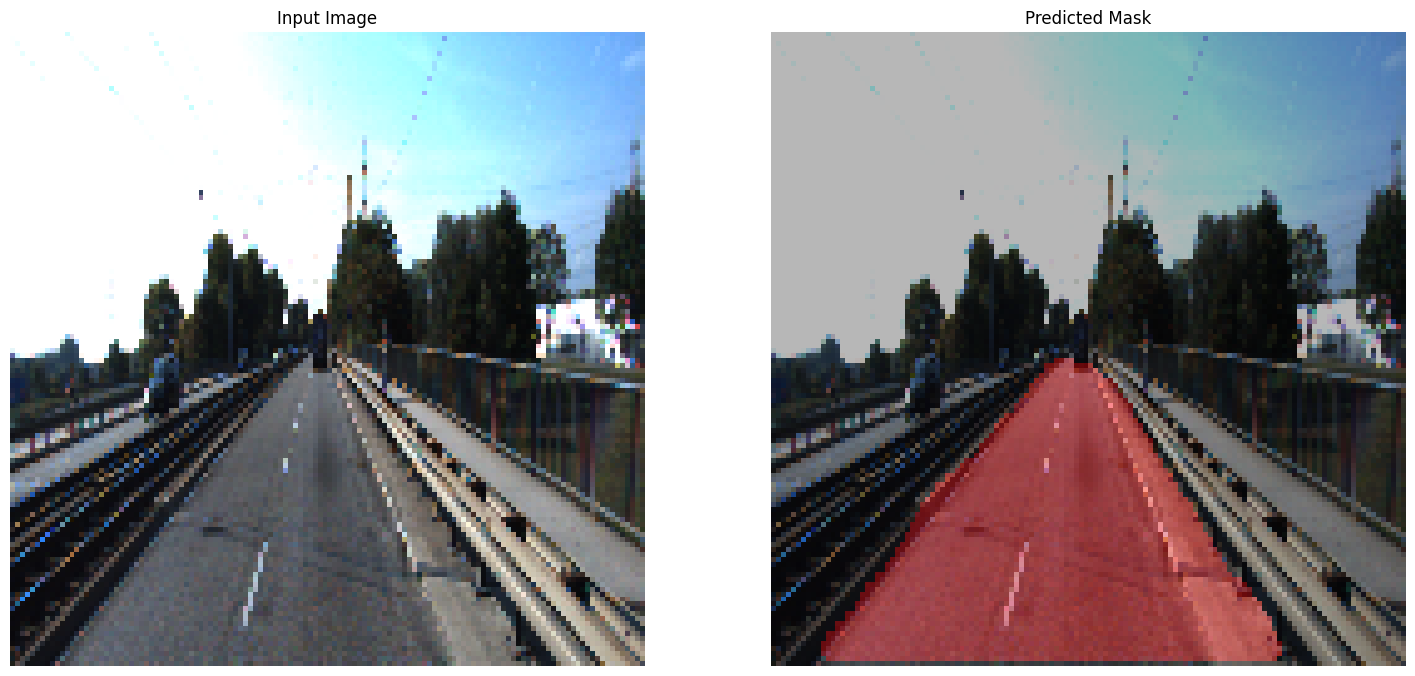

Processing image : 29
1/1 [==============================] - 0s 18ms/step


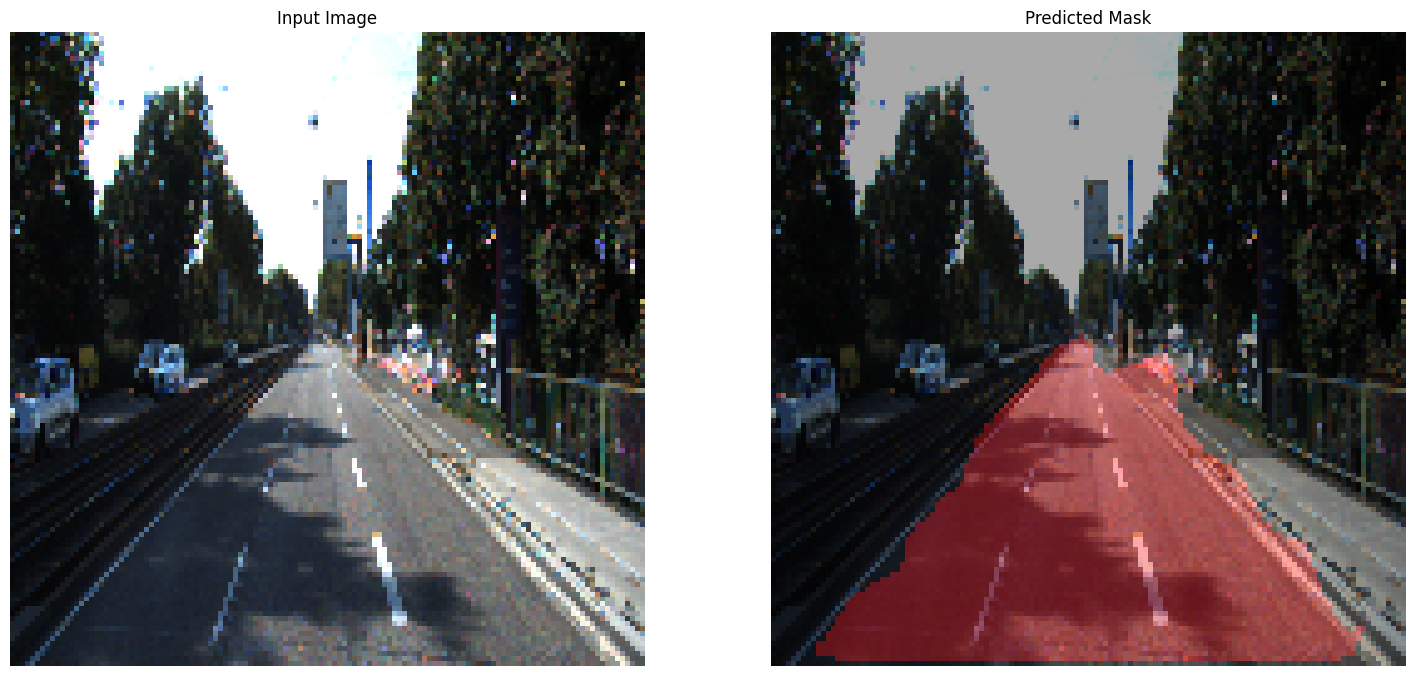

In [ ]:
save_predictions(dataset['test'])

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")
    return image

# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
image_path = '/content/drive/MyDrive/Neural_Network_Project/road_segmentation/live_test/test.jpeg'
image = load_image(image_path)
new_image = process_image(image)
save_path = '/content/drive/MyDrive/Neural_Network_Project/road_segmentation/live_test/processed.jpeg'
cv2.imwrite(save_path, new_image)

1/1 [==============================] - 0s 161ms/step


<ipython-input-27-f816aa67bda7>:3: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  new_image = process_image(image)


True

## Loading Pretrained VGG for Testing

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Neural_Network_Project/road_segmentation/Trained_models/VGG/best_model.h5')

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")
    return image


def weighted_img(img, initial_img, alpha=1., beta=0.5, gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)


# Function to process an individual image
def process_image(image):
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
IMG_SIZE = 128
SEED = 123

image_path = '/content/drive/MyDrive/Neural_Network_Project/road_segmentation/live_test/test2.jpeg'
image = load_image(image_path)
new_image = process_image(image)
save_path = '/content/drive/MyDrive/Neural_Network_Project/road_segmentation/live_test/processed2.jpeg'
cv2.imwrite(save_path, new_image)

1/1 [==============================] - 3s 3s/step


<ipython-input-8-bbf4417f3dbd>:6: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  new_image = process_image(image)


True

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


## GoogLeNet Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, concatenate
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 conv
    conv1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 conv
    conv3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv3x3)

    # 5x5 conv
    conv5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv5x5)

    # 3x3 max pool
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool)

    # concatenate filters, assumes filters are last dimension
    output = concatenate([conv1x1, conv3x3, conv5x5, pool], axis=-1)
    return output

def create_googlenet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Initial convolution and pooling layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Multiple Inception modules stacked together
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Upsampling to the original image size
    x = UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]))(x)

    # Output convolutional layer with a single filter and sigmoid activation for binary segmentation
    output = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Create model
    model = Model(inputs, output, name='googlenet')
    return model

# Create the model
googlenet_model = create_googlenet()
googlenet_model.summary()


Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_118 (Conv2D)         (None, 64, 64, 64)           9472      ['input_12[0][0]']            
                                                                                                  
 max_pooling2d_34 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_118[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_120 (Conv2D)         (None, 32, 32, 96)           6240      ['max_pooling2d_34[0][

In [ ]:
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions('GoogleNet_outputs/input_true_pred', googlenet_model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("/content/drive/MyDrive/Neural_Network_Project/road_segmentation/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callback_functions = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('/content/drive/MyDrive/Neural_Network_Project/road_segmentation/Trained_models/GoogleNet/googlenet_best_model.h5', verbose = 1, save_best_only = True)
]

In [ ]:
# Set Variables
EPOCHS = 100
STEPS_PER_EPOCH = math.ceil(TRAINSET_SIZE / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(VALIDSET_SIZE / BATCH_SIZE)

In [ ]:
m_iou = tf.keras.metrics.MeanIoU(2)
googlenet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[m_iou])

1/1 [==============================] - 0s 24ms/step
Filepath:  /content/drive/MyDrive/Neural_Network_Project/road_segmentation/saved_pred_masks/GoogleNet_outputs/input_true_pred (57).png


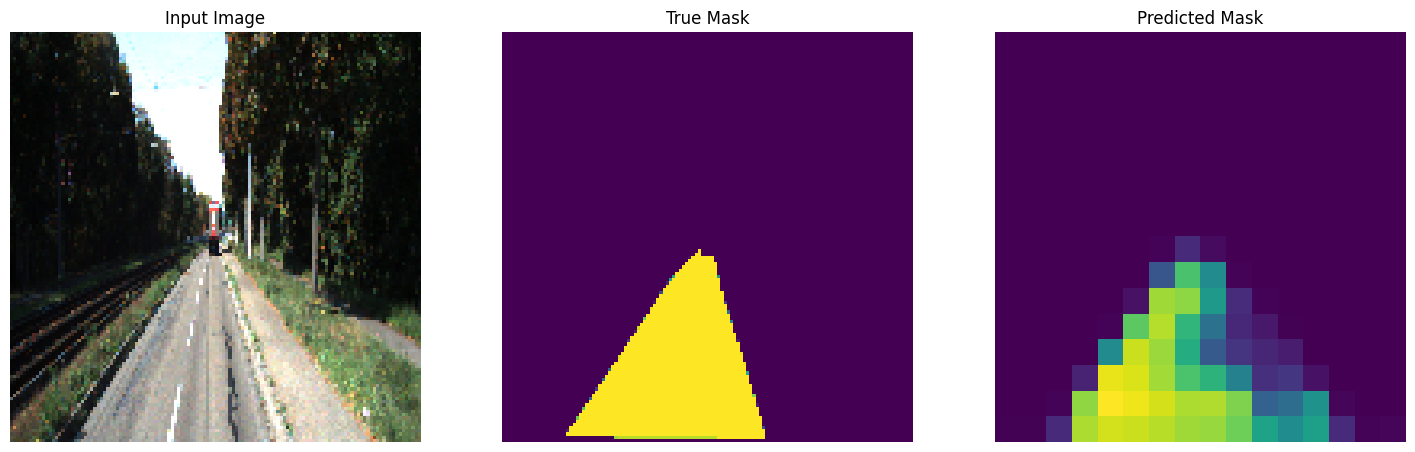


Sample Prediction after epoch 58


Epoch 58: val_loss did not improve from 0.11312
8/8 [==============================] - 18s 3s/step - loss: 0.1222 - mean_io_u_9: 0.4112 - val_loss: 0.1183 - val_mean_io_u_9: 0.3981
Epoch 58: early stopping


In [ ]:
googlenet_model_history = googlenet_model.fit(dataset['train'], epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data = dataset["val"], validation_steps=VALIDATION_STEPS, callbacks=callback_functions)

### U-Net + Inception Module

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
    return output

def create_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # First Convolutional Layer
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    pool1 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv1)

    # Inception module 1
    inception1 = inception_module(pool1, 64, 96, 128, 16, 32, 32)

    # Add more Inception modules as needed

    # Upsampling
    up1 = UpSampling2D((2, 2))(inception1)
    conv_up1 = Conv2D(64, (3, 3), padding='same', activation='relu')(up1)

    up2 = UpSampling2D((2, 2))(conv_up1)
    conv_up2 = Conv2D(32, (3, 3), padding='same', activation='relu')(up2)

    # Output
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv_up2)

    model = Model(inputs, output, name='unet')
    return model

# Example usage:
unet_model = create_unet()
unet_model.summary()


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                               
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 96)           6240      ['max_pooling2d[0][0]']    

In [ ]:
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions('UNet_outputs/input_true_pred', model=unet_model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("/content/drive/MyDrive/Neural_Network_Project/road_segmentation/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callback_functions = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('/content/drive/MyDrive/Neural_Network_Project/road_segmentation/Trained_models/UNet/unet_best_model.h5', verbose = 1, save_best_only = True)
]

In [ ]:
# Set Variables
EPOCHS = 100
STEPS_PER_EPOCH = math.ceil(TRAINSET_SIZE / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(VALIDSET_SIZE / BATCH_SIZE)

In [ ]:
m_iou = tf.keras.metrics.MeanIoU(2)
unet_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[m_iou])

1/1 [==============================] - 0s 21ms/step
Filepath:  /content/drive/MyDrive/Neural_Network_Project/road_segmentation/saved_pred_masks/UNet_outputs/input_true_pred (58).png


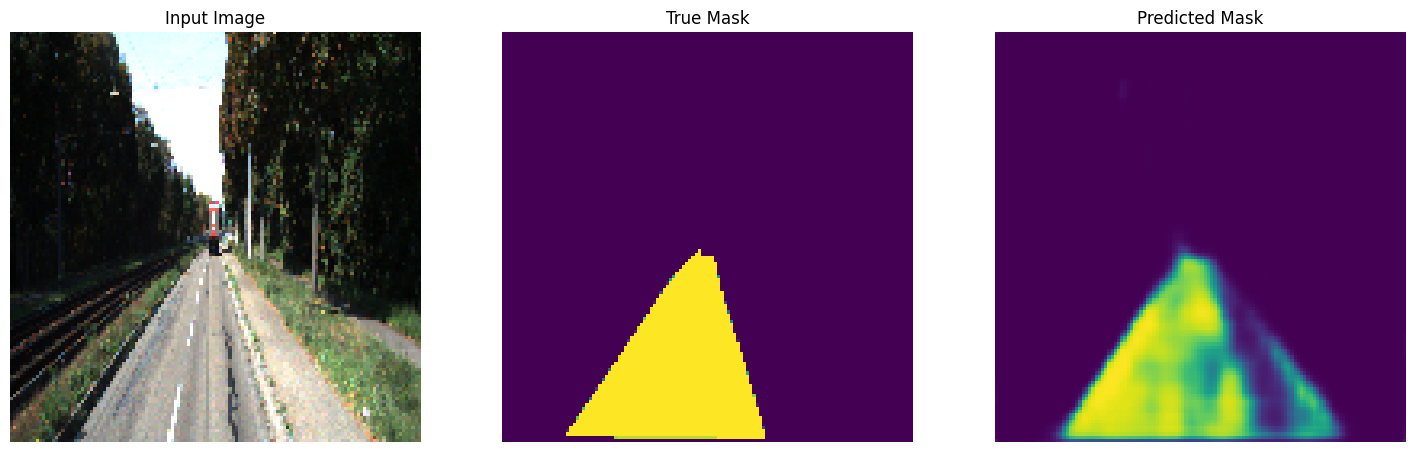


Sample Prediction after epoch 59


Epoch 59: val_loss did not improve from 0.09899
8/8 [==============================] - 22s 3s/step - loss: 0.1142 - mean_io_u_2: 0.4155 - val_loss: 0.1085 - val_mean_io_u_2: 0.4102
Epoch 59: early stopping


In [ ]:
unet_model_history = unet_model.fit(dataset['train'], epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data = dataset["val"], validation_steps=VALIDATION_STEPS, callbacks=callback_functions)

## UNet Pretrained

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Neural_Network_Project/road_segmentation/Trained_models/UNet/unet_best_model.h5')

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")
    return image


def weighted_img(img, initial_img, alpha=1., beta=0.5, gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)


# Function to process an individual image
def process_image(image):
    print(model.summary)
    # Preprocess image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
IMG_SIZE = 128
SEED = 123

image_path = '/content/drive/MyDrive/Neural_Network_Project/road_segmentation/live_test/test2.jpeg'
image = load_image(image_path)
new_image = process_image(image)
save_path = '/content/drive/MyDrive/Neural_Network_Project/road_segmentation/live_test/processed_with_unet2.jpeg'
cv2.imwrite(save_path, new_image)

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7d67472e6200>>
1/1 [==============================] - 0s 29ms/step


<ipython-input-26-666b11c9c70b>:6: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  new_image = process_image(image)


True